### Bisulfite sequencing Analysis Workflow in Jupyter Notebook
##### Project overview
- **Study:** Xmal-RRBS on breast carcinoma before and after **neoadjuvant chemotherapy**
- **Dataset:** Series Accession: GSE202402
- **Technology:** Xmal-RRBS (Reduced Representation Bisulfite Sequencing)
    - More cost effective than Whole-Genome Bisulfite Sequencing (WGBS)
    - Captures CpG-rich regions efficiently, enabling methylation analysis with lower sequencing depth

##### Study Design & Sample Selection
  - Pre- and post-chemotherapy paired samples
  - Focus on Partial Response (PR) cases
    - Ensures biologically meaningful comparisons
    - Helps identify **chemotherapy-induced epigenetic changes

##### Steps Covered in the Workflow
  1. Data Acquisition & Preprocessing
  * Download files
      - Genome reference and annotation
      - FASTQ files: RRBS data
  * Perform Quality Control on Raw Reads 
      - Tools used: `FastQC`
      - Key metrics checked
          - Read quality distribution
          - Adapter contamination
          - GC content bias
  * Read Trimming and Adapter Removal
      - Tools used: `Trim Galore`
      - Ensures:
          - Removal of low-quality bases
          - Trimming of adapter sequences

  2. Read Alignment & Remove Duplicates
  * Align Reads to Reference Genome
      - Tools Used: Bismark (Bowtie2- based)
      - Process:
          - Bisulfite conversion-aware mapping
  * Sort Aligned SAM Files into BAM Files and Index it
      - Tools Used: Samtools
  * Check & Remove Duplicates 
      - Tools Used: Bismark
      - Outputs deduplicated, sorted BAM files
  
  3. Methylation Calling 
  * Methylation extraction
      - Tools Used: Bismark
      - Generates reports that summarizes the methylation levels at different sites (CpG, CHH and CHG)
      - Output results in different formats
          * BedGraph file: Used for visualization in genome browsers
          * Cytosine report: Shows how much of the DNA is methylated
          * Coverage files: Shows how well each region was sequenced
  * Running Bismark reports
      - Run Bismark reports for each sample
      - Create individual HTML reports
      - Attempt to generate a summary report (FAILED)
      - Manually create CX reports to generate a Methylation Summary report
  
  4. Visualization
  
  5. CX Report conversion for DMR/DML Analysis
      - Convert CX report into DSS format
      - Groups data by chromosome and position to create methylation count tables
      - DSS file is then used for DML/DMR analysis in R
---

In [1]:
# Import necessary libraries
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import subprocess

In [2]:
# Define directories
base_dir = "/home/abhi39/Projects/Bisulfite_seq"
os.makedirs(base_dir, exist_ok = True)

data_dir = os.path.join(base_dir, "data")
reads_dir = os.path.join(data_dir, "reads")
os.makedirs(data_dir, exist_ok = True)
os.makedirs(reads_dir, exist_ok = True)

reference_dir = os.path.join(base_dir, "reference")
genome_dir = os.path.join(reference_dir, "genome")
annotation_dir = os.path.join(reference_dir, "annotation")
index_dir = os.path.join(genome_dir, "bismark")
os.makedirs(reference_dir, exist_ok = True)
os.makedirs(genome_dir, exist_ok = True)
os.makedirs(annotation_dir, exist_ok = True)
os.makedirs(index_dir, exist_ok = True)

# Output directories for processed data
output_dir = os.path.join(base_dir, "output")
os.makedirs(output_dir, exist_ok=True)

# Subdirectories under output
qc_dir = os.path.join(output_dir, "1_quality_control")  # FastQC, MultiQC reports
trimmed_dir = os.path.join(output_dir, "2_trimmed_reads")  # Trimmed FASTQ files
aligned_dir = os.path.join(output_dir, "3_aligned_reads")  # BAM/SAM files
methylation_dir = os.path.join(output_dir, "4_methylation_calls")  # Methylation status files
dmr_dir = os.path.join(output_dir, "5_differential_methylation")  # DMR analysis results
annotation_results_dir = os.path.join(output_dir, "6_annotation_results")  # Functional annotation
visualization_dir = os.path.join(output_dir, "7_visualizations")  # Plots, UCSC browser tracks

# Create output subdirectories
os.makedirs(qc_dir, exist_ok=True)
os.makedirs(trimmed_dir, exist_ok=True)
os.makedirs(aligned_dir, exist_ok=True)
os.makedirs(methylation_dir, exist_ok=True)
os.makedirs(dmr_dir, exist_ok=True)
os.makedirs(annotation_results_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

# Logs and reports
logs_dir = os.path.join(base_dir, "logs")  # Pipeline logs
reports_dir = os.path.join(base_dir, "reports")  # Final analysis reports
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

print("Directory structure created successfully!")


Directory structure created successfully!


#### Step 1: Download required files
##### Step 1.1 Download genome and annotation file

In [3]:
import os
import subprocess

# URLs for the files
urls = {
    "genome": "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/GRCh38.primary_assembly.genome.fa.gz",
    "annotation": "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz",
}

# File paths
output_files = {
    "genome": os.path.join(genome_dir, "GRCh38.primary_assembly.genome.fa.gz"),
    "annotation": os.path.join(annotation_dir, "gencode.v38.annotation.gtf.gz"),
}

# Function to download and decompress files using wget and gunzip
def download_and_decompress_wget(url, output_path):
    # Download file using wget
    try:
        print(f"Downloading {output_path}...")
        subprocess.run(["wget", "-q", "-O", output_path, url], check=True)
        print(f"Downloaded: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download {output_path}. Error: {e}")
        return

    # Decompress file using gunzip
    try:
        print(f"Decompressing {output_path}...")
        subprocess.run(["gunzip", "-f", output_path], check=True)
        print(f"Decompressed to: {output_path[:-3]}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to decompress {output_path}. Error: {e}")

# Download and decompress files
for file_type, url in urls.items():
    download_and_decompress_wget(url, output_files[file_type])

print("All files downloaded and decompressed successfully!")

Downloaded: /home/abhi39/Projects/Bisulfite_seq/reference/genome/GRCh38.primary_assembly.genome.fa.gz
Decompressing /home/abhi39/Projects/Bisulfite_seq/reference/genome/GRCh38.primary_assembly.genome.fa.gz...
Decompressed to: /home/abhi39/Projects/Bisulfite_seq/reference/genome/GRCh38.primary_assembly.genome.fa
Downloaded: /home/abhi39/Projects/Bisulfite_seq/reference/annotation/gencode.v38.annotation.gtf.gz
Decompressing /home/abhi39/Projects/Bisulfite_seq/reference/annotation/gencode.v38.annotation.gtf.gz...
Decompressed to: /home/abhi39/Projects/Bisulfite_seq/reference/annotation/gencode.v38.annotation.gtf
All files downloaded and decompressed successfully!


##### Step 1.2: Download fastq files 

In [ ]:
# Step 1.2 Download fastq files 
import os
import subprocess

os.makedirs(reads_dir, exist_ok = True)

# Download FASTQ files using SRA Toolkit
def download_fastq(srr_id, reads_dir):
    print(f"Downloading FASTQ files for {srr_id}...")
    
    # Use prefetch to download the SRA file
    subprocess.run(["prefetch", srr_id], check=True)
    
    # Use fasterq-dump to extract FASTQ files to the specified directory
    subprocess.run([
        "fasterq-dump", "--outdir", reads_dir, srr_id
    ], check=True)
    
    # Compress the resulting FASTQ files
    for fq_file in os.listdir(reads_dir):
        if fq_file.startswith(srr_id) and fq_file.endswith(".fastq"):
            fq_path = os.path.join(reads_dir, fq_file)
            subprocess.run(["gzip", fq_path], check=True)
            print(f"Compressed: {fq_path}.gz")
    print(f"Downloaded and saved FASTQ files for {srr_id} to {reads_dir}")

# List of SRR IDs
srr_ids = ["SRR19127197", # Pre_chemo_partial_respone_1
           "SRR19127198", # Pre_chemo_partial_respone_2
           "SRR19127202", # Pre_chemo_partial_respone_3
           "SRR19127177", # Post_chemo_partial_respone_1
           "SRR19127178", # Post_chemo_partial_respone_2
           "SRR19127182", # Post_chemo_partial_respone_3

# Download each SRR ID
for srr_id in srr_ids:
    download_fastq(srr_id, reads_dir)

print(f"All FASTQ files are saved in: {reads_dir}")

2025-02-05T21:56:40 prefetch.3.1.1: 1) Resolving 'SRR19127197'...
2025-02-05T21:56:42 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T21:56:42 prefetch.3.1.1: 1) 'SRR19127197' is found locally 
2025-02-05T21:57:07 prefetch.3.1.1: 'SRR19127197' has 0 unresolved dependencies


spots read      : 480,162
reads read      : 480,162
reads written   : 480,162


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127197.fastq.gz
Downloaded and saved FASTQ files for SRR19127197 to /home/abhi39/Projects/Bisulfite_seq/data/reads
2025-02-05T21:57:23 prefetch.3.1.1: 1) Resolving 'SRR19127198'...
2025-02-05T21:57:24 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T21:57:25 prefetch.3.1.1: 1) 'SRR19127198' is found locally 
2025-02-05T21:57:55 prefetch.3.1.1: 'SRR19127198' has 0 unresolved dependencies


spots read      : 635,724
reads read      : 635,724
reads written   : 635,724


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127198.fastq.gz
Downloaded and saved FASTQ files for SRR19127198 to /home/abhi39/Projects/Bisulfite_seq/data/reads
2025-02-05T21:58:14 prefetch.3.1.1: 1) Resolving 'SRR19127202'...
2025-02-05T21:58:15 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T21:58:16 prefetch.3.1.1: 1) 'SRR19127202' is found locally 
2025-02-05T21:58:45 prefetch.3.1.1: 'SRR19127202' has 0 unresolved dependencies


spots read      : 647,816
reads read      : 647,816
reads written   : 647,816


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127202.fastq.gz
Downloaded and saved FASTQ files for SRR19127202 to /home/abhi39/Projects/Bisulfite_seq/data/reads
2025-02-05T21:59:04 prefetch.3.1.1: 1) Resolving 'SRR19127207'...
2025-02-05T21:59:05 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T21:59:06 prefetch.3.1.1: 1) Downloading 'SRR19127207'...
2025-02-05T21:59:06 prefetch.3.1.1:  SRA Normalized Format file is being retrieved
2025-02-05T21:59:06 prefetch.3.1.1:  Downloading via HTTPS...
2025-02-05T21:59:15 prefetch.3.1.1:  HTTPS download succeed
2025-02-05T21:59:16 prefetch.3.1.1:  'SRR19127207' is valid: 69779003 bytes were streamed from 69766681
2025-02-05T21:59:16 prefetch.3.1.1: 1) 'SRR19127207' was downloaded successfully
2025-02-05T21:59:44 prefetch.3.1.1: 'SRR19127207' has 3 unresolved dependencies
2025-02-05T21:59:44 prefetch.3.1.1: 2) Resolving 'ncbi-acc:GL000233.1?vdb-ctx=refseq'

spots read      : 736,601
reads read      : 736,601
reads written   : 736,601


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127207.fastq.gz
Downloaded and saved FASTQ files for SRR19127207 to /home/abhi39/Projects/Bisulfite_seq/data/reads
2025-02-05T22:00:03 prefetch.3.1.1: 1) Resolving 'SRR19127177'...
2025-02-05T22:00:04 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T22:00:05 prefetch.3.1.1: 1) 'SRR19127177' is found locally 
2025-02-05T22:00:29 prefetch.3.1.1: 'SRR19127177' has 0 unresolved dependencies


spots read      : 563,438
reads read      : 563,438
reads written   : 563,438


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127177.fastq.gz
Downloaded and saved FASTQ files for SRR19127177 to /home/abhi39/Projects/Bisulfite_seq/data/reads
2025-02-05T22:00:46 prefetch.3.1.1: 1) Resolving 'SRR19127178'...
2025-02-05T22:00:47 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T22:00:48 prefetch.3.1.1: 1) 'SRR19127178' is found locally 
2025-02-05T22:01:20 prefetch.3.1.1: 'SRR19127178' has 0 unresolved dependencies


spots read      : 721,970
reads read      : 721,970
reads written   : 721,970


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127178.fastq.gz
Downloaded and saved FASTQ files for SRR19127178 to /home/abhi39/Projects/Bisulfite_seq/data/reads
2025-02-05T22:01:40 prefetch.3.1.1: 1) Resolving 'SRR19127182'...
2025-02-05T22:01:42 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T22:01:42 prefetch.3.1.1: 1) 'SRR19127182' is found locally 
2025-02-05T22:02:09 prefetch.3.1.1: 'SRR19127182' has 0 unresolved dependencies


spots read      : 629,056
reads read      : 629,056
reads written   : 629,056


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127182.fastq.gz
Downloaded and saved FASTQ files for SRR19127182 to /home/abhi39/Projects/Bisulfite_seq/data/reads
2025-02-05T22:02:27 prefetch.3.1.1: 1) Resolving 'SRR19127186'...
2025-02-05T22:02:28 prefetch.3.1.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-02-05T22:02:29 prefetch.3.1.1: 1) Downloading 'SRR19127186'...
2025-02-05T22:02:29 prefetch.3.1.1:  SRA Normalized Format file is being retrieved
2025-02-05T22:02:29 prefetch.3.1.1:  Downloading via HTTPS...
2025-02-05T22:02:42 prefetch.3.1.1:  HTTPS download succeed
2025-02-05T22:02:42 prefetch.3.1.1:  'SRR19127186' is valid: 100415965 bytes were streamed from 100412951
2025-02-05T22:02:42 prefetch.3.1.1: 1) 'SRR19127186' was downloaded successfully
2025-02-05T22:03:11 prefetch.3.1.1: 'SRR19127186' has 1 unresolved dependency
2025-02-05T22:03:11 prefetch.3.1.1: 2) Resolving 'ncbi-acc:GL000191.1?vdb-ctx=refseq'

spots read      : 989,944
reads read      : 989,944
reads written   : 989,944


Compressed: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127186.fastq.gz
Downloaded and saved FASTQ files for SRR19127186 to /home/abhi39/Projects/Bisulfite_seq/data/reads
All FASTQ files are saved in: /home/abhi39/Projects/Bisulfite_seq/data/reads


#### Step 2: Perform quality control using fastQC and trim reads using Trim Galore
##### Step 2.1. Run FastQC for initial quality check

In [12]:
import os
import subprocess

# Define the reads directory and QC output directory
qc_dir = os.path.join(output_dir, "1_quality_control")  # FastQC, MultiQC reports
os.makedirs(qc_dir, exist_ok = True)

# Run FastQC on all FASTQ files
def run_fastqc(reads_dir, qc_dir):
    """Run quality control using FastQC on FASTQ files..."""
    print(f"Running quality control using FastQC...")
    fastq_files = [os.path.join(reads_dir, f) for f in os.listdir(reads_dir) if f.endswith(".fastq.gz")]
    if not fastq_files:
        print("No FASTQ files found in the reads directory")
        return
    
    subprocess.run(["fastqc", "-o", qc_dir, "-t", "4"] + fastq_files, check = True)
    print(f"FastQC reports saved in {qc_dir}")

# Execute FastQC
run_fastqc(reads_dir, qc_dir)
    
print("Quality control complete. Review FastQC reports before proceeding to trimming.")

Running quality control using FastQC...
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip


Started analysis of SRR19127202.fastq.gz
Approx 5% complete for SRR19127202.fastq.gz
Approx 10% complete for SRR19127202.fastq.gz
Approx 15% complete for SRR19127202.fastq.gz
Started analysis of SRR19127197.fastq.gz
Approx 20% complete for SRR19127202.fastq.gz
Approx 5% complete for SRR19127197.fastq.gz
Approx 25% complete for SRR19127202.fastq.gz
Approx 10% complete for SRR19127197.fastq.gz
Approx 15% complete for SRR19127197.fastq.gz
Approx 30% complete for SRR19127202.fastq.gz
Approx 20% complete for SRR19127197.fastq.gz
Approx 35% complete for SRR19127202.fastq.gz
Approx 25% complete for SRR19127197.fastq.gz
Started analysis of SRR19127198.fastq.gz
Approx 40% complete for SRR19127202.fastq.gz
Approx 30% complete for SRR19127197.fastq.gz
Approx 5% complete for SRR19127198.fastq.gz
Approx 35% complete for SRR19127197.fastq.gz
Approx 45% complete for SRR19127202.fastq.gz
Approx 10% complete for SRR19127198.fastq.gz
Approx 40% complete for SRR19127197.fastq.gz
Approx 50% complete for S

Analysis complete for SRR19127197.fastq.gz


Approx 30% complete for SRR19127178.fastq.gz
Approx 55% complete for SRR19127198.fastq.gz
Approx 95% complete for SRR19127202.fastq.gz
Approx 35% complete for SRR19127178.fastq.gz
Approx 60% complete for SRR19127198.fastq.gz


Analysis complete for SRR19127202.fastq.gz


Approx 40% complete for SRR19127178.fastq.gz
Approx 65% complete for SRR19127198.fastq.gz
Approx 70% complete for SRR19127198.fastq.gz
Approx 45% complete for SRR19127178.fastq.gz
Approx 75% complete for SRR19127198.fastq.gz
Approx 50% complete for SRR19127178.fastq.gz
Approx 80% complete for SRR19127198.fastq.gz
Started analysis of SRR19127177.fastq.gz
Approx 55% complete for SRR19127178.fastq.gz
Approx 5% complete for SRR19127177.fastq.gz
Approx 85% complete for SRR19127198.fastq.gz
Approx 60% complete for SRR19127178.fastq.gz
Approx 10% complete for SRR19127177.fastq.gz
Approx 90% complete for SRR19127198.fastq.gz
Approx 65% complete for SRR19127178.fastq.gz
Approx 15% complete for SRR19127177.fastq.gz
Approx 95% complete for SRR19127198.fastq.gz
Approx 70% complete for SRR19127178.fastq.gz
Approx 20% complete for SRR19127177.fastq.gz
Started analysis of SRR19127182.fastq.gz


Analysis complete for SRR19127198.fastq.gz


Approx 25% complete for SRR19127177.fastq.gz
Approx 75% complete for SRR19127178.fastq.gz
Approx 30% complete for SRR19127177.fastq.gz
Approx 5% complete for SRR19127182.fastq.gz
Approx 80% complete for SRR19127178.fastq.gz
Approx 35% complete for SRR19127177.fastq.gz
Approx 10% complete for SRR19127182.fastq.gz
Approx 85% complete for SRR19127178.fastq.gz
Approx 40% complete for SRR19127177.fastq.gz
Approx 15% complete for SRR19127182.fastq.gz
Approx 90% complete for SRR19127178.fastq.gz
Approx 45% complete for SRR19127177.fastq.gz
Approx 20% complete for SRR19127182.fastq.gz
Approx 50% complete for SRR19127177.fastq.gz
Approx 95% complete for SRR19127178.fastq.gz
Approx 25% complete for SRR19127182.fastq.gz
Approx 55% complete for SRR19127177.fastq.gz


Analysis complete for SRR19127178.fastq.gz


Approx 30% complete for SRR19127182.fastq.gz
Approx 60% complete for SRR19127177.fastq.gz
Approx 35% complete for SRR19127182.fastq.gz
Approx 65% complete for SRR19127177.fastq.gz
Approx 70% complete for SRR19127177.fastq.gz
Approx 40% complete for SRR19127182.fastq.gz
Approx 75% complete for SRR19127177.fastq.gz
Approx 45% complete for SRR19127182.fastq.gz
Approx 80% complete for SRR19127177.fastq.gz
Approx 50% complete for SRR19127182.fastq.gz
Approx 85% complete for SRR19127177.fastq.gz
Approx 55% complete for SRR19127182.fastq.gz
Approx 90% complete for SRR19127177.fastq.gz
Approx 60% complete for SRR19127182.fastq.gz
Approx 95% complete for SRR19127177.fastq.gz
Approx 65% complete for SRR19127182.fastq.gz


Analysis complete for SRR19127177.fastq.gz


Approx 70% complete for SRR19127182.fastq.gz
Approx 75% complete for SRR19127182.fastq.gz
Approx 80% complete for SRR19127182.fastq.gz
Approx 85% complete for SRR19127182.fastq.gz
Approx 90% complete for SRR19127182.fastq.gz
Approx 95% complete for SRR19127182.fastq.gz


Analysis complete for SRR19127182.fastq.gz
FastQC reports saved in /home/abhi39/Projects/Bisulfite_seq/output/1_quality_control
Quality control complete. Review FastQC reports before proceeding to trimming.


##### Step 2.2: Run MultiQC to summarize FastQC results

In [13]:
def run_multiqc(qc_dir):
    print("Running MultiQC to summarize FastQC reports...")
    subprocess.run(["multiqc", qc_dir, "-o", qc_dir], check=True)
    print(f"MultiQC summary saved in {qc_dir}")

# Execute MultiQC
run_multiqc(qc_dir)

Running MultiQC to summarize FastQC reports...



/// ]8;id=195135;https://multiqc.info\MultiQC]8;;\ 🔍 v1.27

       file_search | Search path: /home/abhi39/Projects/Bisulfite_seq/output/1_quality_control
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 12/12  12  
            fastqc | Found 6 reports
     write_results | Data        : output/1_quality_control/multiqc_data


MultiQC summary saved in /home/abhi39/Projects/Bisulfite_seq/output/1_quality_control


     write_results | Report      : output/1_quality_control/multiqc_report.html
           multiqc | MultiQC complete


##### Key observations after interpreting MultiQC results
* Moderate duplication (21-34%) which is expected for RRBs, but still requires deduplication after alignment
* GC content (31-36%) which falls within expected range for CpG enriched RRBS libraries
* Consistent read lengths (~124bp, except for SRR19127182 at 144bp)
* Decent sequencing depth (0.5-0.7M per sample) which is enough for exploratory methylation analysis



##### Step 2.3: Trim Reads using Trim Galore

In [15]:
import os
import subprocess

# Define directories
base_dir = "/home/abhi39/Projects/Bisulfite_seq"
reads_dir = os.path.join(base_dir, "data", "reads")  # Raw FASTQ files
trim_dir = os.path.join(base_dir, "output", "2_trimmed_reads")  # Trimmed FASTQ files
os.makedirs(trim_dir, exist_ok=True)

# Function to run Trim Galore!
def run_trim_galore(reads_dir, trim_dir):
    """Run Trim Galore! for adapter trimming and quality filtering."""
    print(f"Running Trim Galore! on FASTQ files in {reads_dir}...")

    # List FASTQ files
    fastq_files = [os.path.join(reads_dir, f) for f in os.listdir(reads_dir) if f.endswith(".fastq.gz")]
    
    if not fastq_files:
        print("No FASTQ files found in the reads directory")
        return

    # Run Trim Galore! (optimized for RRBS)
    subprocess.run(["trim_galore", "--rrbs", "--fastqc", "-o", trim_dir] + fastq_files, check=True)

    print(f"Trimmed FASTQ files and reports saved in {trim_dir}")

# Execute Trim Galore!
run_trim_galore(reads_dir, trim_dir)

print("Adapter trimming complete. Review FastQC reports before proceeding to alignment.")

Running Trim Galore! on FASTQ files in /home/abhi39/Projects/Bisulfite_seq/data/reads...
igzip command line interface 2.31.1


Multicore support not enabled. Proceeding with single-core trimming.
Path to Cutadapt set as: 'cutadapt' (default)
Cutadapt seems to be working fine (tested command 'cutadapt --version')
Cutadapt version: 5.0
single-core operation.
igzip detected. Using igzip for decompressing

No quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)

Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/


AUTO-DETECTING ADAPTER TYPE
Attempting to auto-detect adapter type from the first 1 million sequences of the first file (>> /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127202.fastq.gz <<)

Found perfect matches for the following adapter sequences:
Adapter type	Count	Sequence	Sequences analysed	Percentage
smallRNA	0	TGGAATTCTCGG	647816	0.00
Illumina	0	AGATCGGAAGAGC	647816	0.00
Nextera	0	CTGTCTCTTATA	647816	0.00
Unable to auto-detect most prominent adapter from the first specified file (count s

application/gzip


Approx 5% complete for SRR19127202_trimmed.fq.gz
Approx 10% complete for SRR19127202_trimmed.fq.gz
Approx 15% complete for SRR19127202_trimmed.fq.gz
Approx 20% complete for SRR19127202_trimmed.fq.gz
Approx 25% complete for SRR19127202_trimmed.fq.gz
Approx 30% complete for SRR19127202_trimmed.fq.gz
Approx 35% complete for SRR19127202_trimmed.fq.gz
Approx 40% complete for SRR19127202_trimmed.fq.gz
Approx 45% complete for SRR19127202_trimmed.fq.gz
Approx 50% complete for SRR19127202_trimmed.fq.gz
Approx 55% complete for SRR19127202_trimmed.fq.gz
Approx 60% complete for SRR19127202_trimmed.fq.gz
Approx 65% complete for SRR19127202_trimmed.fq.gz
Approx 70% complete for SRR19127202_trimmed.fq.gz
Approx 75% complete for SRR19127202_trimmed.fq.gz
Approx 80% complete for SRR19127202_trimmed.fq.gz
Approx 85% complete for SRR19127202_trimmed.fq.gz
Approx 90% complete for SRR19127202_trimmed.fq.gz
Approx 95% complete for SRR19127202_trimmed.fq.gz


Analysis complete for SRR19127202_trimmed.fq.gz


Writing report to '/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127197.fastq.gz_trimming_report.txt'

SUMMARISING RUN PARAMETERS
Input filename: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127197.fastq.gz
Trimming mode: single-end
Trim Galore version: 0.6.10
Cutadapt version: 5.0
Number of cores used for trimming: 1
Quality Phred score cutoff: 20
Quality encoding type selected: ASCII+33
Adapter sequence: 'AGATCGGAAGAGC' (Illumina TruSeq, Sanger iPCR; default (inconclusive auto-detection))
Maximum trimming error rate: 0.1 (default)
Minimum required adapter overlap (stringency): 1 bp
Minimum required sequence length before a sequence gets removed: 20 bp
File was specified to be an MspI-digested RRBS sample. Read 1 sequences with adapter contamination will be trimmed a further 2 bp from their 3' end, and Read 2 sequences will be trimmed by 2 bp from their 5' end to remove potential methylation-biased bases from the end-repair reaction
Running FastQC on the data 

application/gzip


Approx 5% complete for SRR19127197_trimmed.fq.gz
Approx 10% complete for SRR19127197_trimmed.fq.gz
Approx 15% complete for SRR19127197_trimmed.fq.gz
Approx 20% complete for SRR19127197_trimmed.fq.gz
Approx 25% complete for SRR19127197_trimmed.fq.gz
Approx 30% complete for SRR19127197_trimmed.fq.gz
Approx 35% complete for SRR19127197_trimmed.fq.gz
Approx 40% complete for SRR19127197_trimmed.fq.gz
Approx 45% complete for SRR19127197_trimmed.fq.gz
Approx 50% complete for SRR19127197_trimmed.fq.gz
Approx 55% complete for SRR19127197_trimmed.fq.gz
Approx 60% complete for SRR19127197_trimmed.fq.gz
Approx 65% complete for SRR19127197_trimmed.fq.gz
Approx 70% complete for SRR19127197_trimmed.fq.gz
Approx 75% complete for SRR19127197_trimmed.fq.gz
Approx 80% complete for SRR19127197_trimmed.fq.gz
Approx 85% complete for SRR19127197_trimmed.fq.gz
Approx 90% complete for SRR19127197_trimmed.fq.gz
Approx 95% complete for SRR19127197_trimmed.fq.gz


Analysis complete for SRR19127197_trimmed.fq.gz


Writing report to '/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127198.fastq.gz_trimming_report.txt'

SUMMARISING RUN PARAMETERS
Input filename: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127198.fastq.gz
Trimming mode: single-end
Trim Galore version: 0.6.10
Cutadapt version: 5.0
Number of cores used for trimming: 1
Quality Phred score cutoff: 20
Quality encoding type selected: ASCII+33
Adapter sequence: 'AGATCGGAAGAGC' (Illumina TruSeq, Sanger iPCR; default (inconclusive auto-detection))
Maximum trimming error rate: 0.1 (default)
Minimum required adapter overlap (stringency): 1 bp
Minimum required sequence length before a sequence gets removed: 20 bp
File was specified to be an MspI-digested RRBS sample. Read 1 sequences with adapter contamination will be trimmed a further 2 bp from their 3' end, and Read 2 sequences will be trimmed by 2 bp from their 5' end to remove potential methylation-biased bases from the end-repair reaction
Running FastQC on the data 

application/gzip


Approx 5% complete for SRR19127198_trimmed.fq.gz
Approx 10% complete for SRR19127198_trimmed.fq.gz
Approx 15% complete for SRR19127198_trimmed.fq.gz
Approx 20% complete for SRR19127198_trimmed.fq.gz
Approx 25% complete for SRR19127198_trimmed.fq.gz
Approx 30% complete for SRR19127198_trimmed.fq.gz
Approx 35% complete for SRR19127198_trimmed.fq.gz
Approx 40% complete for SRR19127198_trimmed.fq.gz
Approx 45% complete for SRR19127198_trimmed.fq.gz
Approx 50% complete for SRR19127198_trimmed.fq.gz
Approx 55% complete for SRR19127198_trimmed.fq.gz
Approx 60% complete for SRR19127198_trimmed.fq.gz
Approx 65% complete for SRR19127198_trimmed.fq.gz
Approx 70% complete for SRR19127198_trimmed.fq.gz
Approx 75% complete for SRR19127198_trimmed.fq.gz
Approx 80% complete for SRR19127198_trimmed.fq.gz
Approx 85% complete for SRR19127198_trimmed.fq.gz
Approx 90% complete for SRR19127198_trimmed.fq.gz
Approx 95% complete for SRR19127198_trimmed.fq.gz


Analysis complete for SRR19127198_trimmed.fq.gz


Writing report to '/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127178.fastq.gz_trimming_report.txt'

SUMMARISING RUN PARAMETERS
Input filename: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127178.fastq.gz
Trimming mode: single-end
Trim Galore version: 0.6.10
Cutadapt version: 5.0
Number of cores used for trimming: 1
Quality Phred score cutoff: 20
Quality encoding type selected: ASCII+33
Adapter sequence: 'AGATCGGAAGAGC' (Illumina TruSeq, Sanger iPCR; default (inconclusive auto-detection))
Maximum trimming error rate: 0.1 (default)
Minimum required adapter overlap (stringency): 1 bp
Minimum required sequence length before a sequence gets removed: 20 bp
File was specified to be an MspI-digested RRBS sample. Read 1 sequences with adapter contamination will be trimmed a further 2 bp from their 3' end, and Read 2 sequences will be trimmed by 2 bp from their 5' end to remove potential methylation-biased bases from the end-repair reaction
Running FastQC on the data 

application/gzip


Approx 5% complete for SRR19127178_trimmed.fq.gz
Approx 10% complete for SRR19127178_trimmed.fq.gz
Approx 15% complete for SRR19127178_trimmed.fq.gz
Approx 20% complete for SRR19127178_trimmed.fq.gz
Approx 25% complete for SRR19127178_trimmed.fq.gz
Approx 30% complete for SRR19127178_trimmed.fq.gz
Approx 35% complete for SRR19127178_trimmed.fq.gz
Approx 40% complete for SRR19127178_trimmed.fq.gz
Approx 45% complete for SRR19127178_trimmed.fq.gz
Approx 50% complete for SRR19127178_trimmed.fq.gz
Approx 55% complete for SRR19127178_trimmed.fq.gz
Approx 60% complete for SRR19127178_trimmed.fq.gz
Approx 65% complete for SRR19127178_trimmed.fq.gz
Approx 70% complete for SRR19127178_trimmed.fq.gz
Approx 75% complete for SRR19127178_trimmed.fq.gz
Approx 80% complete for SRR19127178_trimmed.fq.gz
Approx 85% complete for SRR19127178_trimmed.fq.gz
Approx 90% complete for SRR19127178_trimmed.fq.gz
Approx 95% complete for SRR19127178_trimmed.fq.gz


Analysis complete for SRR19127178_trimmed.fq.gz


Writing report to '/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127177.fastq.gz_trimming_report.txt'

SUMMARISING RUN PARAMETERS
Input filename: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127177.fastq.gz
Trimming mode: single-end
Trim Galore version: 0.6.10
Cutadapt version: 5.0
Number of cores used for trimming: 1
Quality Phred score cutoff: 20
Quality encoding type selected: ASCII+33
Adapter sequence: 'AGATCGGAAGAGC' (Illumina TruSeq, Sanger iPCR; default (inconclusive auto-detection))
Maximum trimming error rate: 0.1 (default)
Minimum required adapter overlap (stringency): 1 bp
Minimum required sequence length before a sequence gets removed: 20 bp
File was specified to be an MspI-digested RRBS sample. Read 1 sequences with adapter contamination will be trimmed a further 2 bp from their 3' end, and Read 2 sequences will be trimmed by 2 bp from their 5' end to remove potential methylation-biased bases from the end-repair reaction
Running FastQC on the data 

application/gzip


Approx 5% complete for SRR19127177_trimmed.fq.gz
Approx 10% complete for SRR19127177_trimmed.fq.gz
Approx 15% complete for SRR19127177_trimmed.fq.gz
Approx 20% complete for SRR19127177_trimmed.fq.gz
Approx 25% complete for SRR19127177_trimmed.fq.gz
Approx 30% complete for SRR19127177_trimmed.fq.gz
Approx 35% complete for SRR19127177_trimmed.fq.gz
Approx 40% complete for SRR19127177_trimmed.fq.gz
Approx 45% complete for SRR19127177_trimmed.fq.gz
Approx 50% complete for SRR19127177_trimmed.fq.gz
Approx 55% complete for SRR19127177_trimmed.fq.gz
Approx 60% complete for SRR19127177_trimmed.fq.gz
Approx 65% complete for SRR19127177_trimmed.fq.gz
Approx 70% complete for SRR19127177_trimmed.fq.gz
Approx 75% complete for SRR19127177_trimmed.fq.gz
Approx 80% complete for SRR19127177_trimmed.fq.gz
Approx 85% complete for SRR19127177_trimmed.fq.gz
Approx 90% complete for SRR19127177_trimmed.fq.gz
Approx 95% complete for SRR19127177_trimmed.fq.gz
Approx 100% complete for SRR19127177_trimmed.fq.gz


Analysis complete for SRR19127177_trimmed.fq.gz


Writing report to '/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127182.fastq.gz_trimming_report.txt'

SUMMARISING RUN PARAMETERS
Input filename: /home/abhi39/Projects/Bisulfite_seq/data/reads/SRR19127182.fastq.gz
Trimming mode: single-end
Trim Galore version: 0.6.10
Cutadapt version: 5.0
Number of cores used for trimming: 1
Quality Phred score cutoff: 20
Quality encoding type selected: ASCII+33
Adapter sequence: 'AGATCGGAAGAGC' (Illumina TruSeq, Sanger iPCR; default (inconclusive auto-detection))
Maximum trimming error rate: 0.1 (default)
Minimum required adapter overlap (stringency): 1 bp
Minimum required sequence length before a sequence gets removed: 20 bp
File was specified to be an MspI-digested RRBS sample. Read 1 sequences with adapter contamination will be trimmed a further 2 bp from their 3' end, and Read 2 sequences will be trimmed by 2 bp from their 5' end to remove potential methylation-biased bases from the end-repair reaction
Running FastQC on the data 

application/gzip


Approx 5% complete for SRR19127182_trimmed.fq.gz
Approx 10% complete for SRR19127182_trimmed.fq.gz
Approx 15% complete for SRR19127182_trimmed.fq.gz
Approx 20% complete for SRR19127182_trimmed.fq.gz
Approx 25% complete for SRR19127182_trimmed.fq.gz
Approx 30% complete for SRR19127182_trimmed.fq.gz
Approx 35% complete for SRR19127182_trimmed.fq.gz
Approx 40% complete for SRR19127182_trimmed.fq.gz
Approx 45% complete for SRR19127182_trimmed.fq.gz
Approx 50% complete for SRR19127182_trimmed.fq.gz
Approx 55% complete for SRR19127182_trimmed.fq.gz
Approx 60% complete for SRR19127182_trimmed.fq.gz
Approx 65% complete for SRR19127182_trimmed.fq.gz
Approx 70% complete for SRR19127182_trimmed.fq.gz
Approx 75% complete for SRR19127182_trimmed.fq.gz
Approx 80% complete for SRR19127182_trimmed.fq.gz
Approx 85% complete for SRR19127182_trimmed.fq.gz
Approx 90% complete for SRR19127182_trimmed.fq.gz
Approx 95% complete for SRR19127182_trimmed.fq.gz


Analysis complete for SRR19127182_trimmed.fq.gz
Trimmed FASTQ files and reports saved in /home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads
Adapter trimming complete. Review FastQC reports before proceeding to alignment.


##### Step 2.4: Run QC on trimmed reads

In [16]:
import os
import subprocess

# Define the reads directory and QC output directory
qc_dir = os.path.join(output_dir, "1_quality_control")  # FastQC, MultiQC reports
os.makedirs(qc_dir, exist_ok = True)
qc_trim_dir = os.path.join(qc_dir, "qc_trim")
os.makedirs(qc_trim_dir, exist_ok = True)

# Run FastQC on all FASTQ files
def run_fastqc(trim_dir, qc_trim_dir):
    """Run quality control using FastQC on trimmed FASTQ files..."""
    print(f"Running quality control using FastQC...")
    trim_fastq_files = [os.path.join(trim_dir, f) for f in os.listdir(trim_dir) if f.endswith(".fq.gz")]
    if not trim_fastq_files:
        print("No FASTQ files found in the reads directory")
        return
    
    subprocess.run(["fastqc", "-o", qc_trim_dir, "-t", "4"] + trim_fastq_files, check = True)
    print(f"FastQC reports saved in {qc_trim_dir}")

# Execute FastQC
run_fastqc(trim_dir, qc_trim_dir)
    
print("Quality control complete. Review FastQC reports before proceeding to trimming.")

Running quality control using FastQC...
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip


Started analysis of SRR19127198_trimmed.fq.gz
Approx 5% complete for SRR19127198_trimmed.fq.gz
Approx 10% complete for SRR19127198_trimmed.fq.gz
Approx 15% complete for SRR19127198_trimmed.fq.gz
Started analysis of SRR19127177_trimmed.fq.gz
Approx 20% complete for SRR19127198_trimmed.fq.gz
Approx 5% complete for SRR19127177_trimmed.fq.gz
Approx 25% complete for SRR19127198_trimmed.fq.gz
Approx 10% complete for SRR19127177_trimmed.fq.gz
Approx 30% complete for SRR19127198_trimmed.fq.gz
Approx 15% complete for SRR19127177_trimmed.fq.gz
Approx 35% complete for SRR19127198_trimmed.fq.gz
Approx 20% complete for SRR19127177_trimmed.fq.gz
Started analysis of SRR19127182_trimmed.fq.gz
Approx 25% complete for SRR19127177_trimmed.fq.gz
Approx 40% complete for SRR19127198_trimmed.fq.gz
Approx 5% complete for SRR19127182_trimmed.fq.gz
Approx 30% complete for SRR19127177_trimmed.fq.gz
Approx 45% complete for SRR19127198_trimmed.fq.gz
Approx 10% complete for SRR19127182_trimmed.fq.gz
Approx 35% comp

Analysis complete for SRR19127198_trimmed.fq.gz
Analysis complete for SRR19127177_trimmed.fq.gz


Approx 70% complete for SRR19127182_trimmed.fq.gz
Approx 50% complete for SRR19127202_trimmed.fq.gz
Approx 55% complete for SRR19127202_trimmed.fq.gz
Approx 75% complete for SRR19127182_trimmed.fq.gz
Approx 80% complete for SRR19127182_trimmed.fq.gz
Approx 60% complete for SRR19127202_trimmed.fq.gz
Approx 65% complete for SRR19127202_trimmed.fq.gz
Approx 85% complete for SRR19127182_trimmed.fq.gz
Approx 70% complete for SRR19127202_trimmed.fq.gz
Approx 90% complete for SRR19127182_trimmed.fq.gz
Approx 75% complete for SRR19127202_trimmed.fq.gz
Approx 95% complete for SRR19127182_trimmed.fq.gz


Analysis complete for SRR19127182_trimmed.fq.gz


Approx 80% complete for SRR19127202_trimmed.fq.gz
Approx 85% complete for SRR19127202_trimmed.fq.gz
Started analysis of SRR19127178_trimmed.fq.gz
Approx 90% complete for SRR19127202_trimmed.fq.gz
Approx 5% complete for SRR19127178_trimmed.fq.gz
Approx 95% complete for SRR19127202_trimmed.fq.gz
Approx 10% complete for SRR19127178_trimmed.fq.gz


Analysis complete for SRR19127202_trimmed.fq.gz


Approx 15% complete for SRR19127178_trimmed.fq.gz
Approx 20% complete for SRR19127178_trimmed.fq.gz
Started analysis of SRR19127197_trimmed.fq.gz
Approx 5% complete for SRR19127197_trimmed.fq.gz
Approx 25% complete for SRR19127178_trimmed.fq.gz
Approx 10% complete for SRR19127197_trimmed.fq.gz
Approx 30% complete for SRR19127178_trimmed.fq.gz
Approx 15% complete for SRR19127197_trimmed.fq.gz
Approx 20% complete for SRR19127197_trimmed.fq.gz
Approx 35% complete for SRR19127178_trimmed.fq.gz
Approx 25% complete for SRR19127197_trimmed.fq.gz
Approx 40% complete for SRR19127178_trimmed.fq.gz
Approx 30% complete for SRR19127197_trimmed.fq.gz
Approx 45% complete for SRR19127178_trimmed.fq.gz
Approx 35% complete for SRR19127197_trimmed.fq.gz
Approx 40% complete for SRR19127197_trimmed.fq.gz
Approx 50% complete for SRR19127178_trimmed.fq.gz
Approx 45% complete for SRR19127197_trimmed.fq.gz
Approx 55% complete for SRR19127178_trimmed.fq.gz
Approx 50% complete for SRR19127197_trimmed.fq.gz
Appro

Analysis complete for SRR19127197_trimmed.fq.gz


Approx 95% complete for SRR19127178_trimmed.fq.gz


Analysis complete for SRR19127178_trimmed.fq.gz
FastQC reports saved in /home/abhi39/Projects/Bisulfite_seq/output/1_quality_control/qc_trim
Quality control complete. Review FastQC reports before proceeding to trimming.


##### Step 2.5: MultiQC on FastQC reports of trimmed reads

In [17]:
def run_multiqc(qc_trim_dir):
    print("Running MultiQC to summarize FastQC reports...")
    subprocess.run(["multiqc", qc_trim_dir, "-o", qc_trim_dir], check=True)
    print(f"MultiQC summary saved in {qc_trim_dir}")

# Execute MultiQC
run_multiqc(qc_trim_dir)

Running MultiQC to summarize FastQC reports...



/// ]8;id=610913;https://multiqc.info\MultiQC]8;;\ 🔍 v1.27

       file_search | Search path: /home/abhi39/Projects/Bisulfite_seq/output/1_quality_control/qc_trim
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 12/12  12  
            fastqc | Found 6 reports


MultiQC summary saved in /home/abhi39/Projects/Bisulfite_seq/output/1_quality_control/qc_trim


     write_results | Data        : output/1_quality_control/qc_trim/multiqc_data
     write_results | Report      : output/1_quality_control/qc_trim/multiqc_report.html
           multiqc | MultiQC complete


* Reads look good. Proceed 

#### Step 3: Index the reference genome and align reads to the reference genome
##### 3.1 Index the reference genome

In [25]:
# index reference genome using bismark
import os
import subprocess

# Define reference genome and index directory
genome_dir = os.path.join(reference_dir, "genome")
index_dir = os.path.join(genome_dir, "bismark")
os.makedirs(index_dir, exist_ok=True)  # Create index directory if it doesn't exist
reference_genome = os.path.join(index_dir, "GRCh38.primary_assembly.genome.fa")

def index_reference_genome_bismark(index_dir):
    """
    Index the reference genome using Bismark.

    Parameters:
        reference_genome (str): Path to the reference genome FASTA file.
        index_dir (str): Directory to save Bismark index files.
    """
    print(f"Indexing reference genome with Bismark: {index_dir}...")


    # Run Bismark index command
    bismark_index_cmd = ["bismark_genome_preparation", "--bowtie2", index_dir
    ]
    
    subprocess.run(bismark_index_cmd, check=True)
    
    print(f"Indexing complete. Bismark index saved in: {index_dir}")



# Index the reference genome with Bismark
index_reference_genome_bismark(index_dir)

Indexing reference genome with Bismark: /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark...


Writing bisulfite genomes out into a single MFA (multi FastA) file

Bisulfite Genome Indexer version v0.24.2 (last modified: 19 May 2022)

Step I - Prepare genome folders - completed



Step II - Genome bisulfite conversions - completed


Bismark Genome Preparation - Step III: Launching the Bowtie 2 indexer



Total number of conversions performed:
C->T:	601242978
G->A:	603830515
Please be aware that this process can - depending on genome size - take several hours!
Settings:
  Output files: "BS_CT.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  genome_mfa.CT_conversion.fa
Reading reference sizes


Building a SMALL index


Settings:
  Output files: "BS_GA.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  genome_mfa.GA_conversion.fa
Reading reference sizes


Building a SMALL index


  Time reading reference sizes: 00:00:08
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time reading reference sizes: 00:00:08
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:06
bmax according to bmaxDivN setting: 737156938
Using parameters --bmax 552867704 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 552867704 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample
  Building sPrime
  Building sPrimeOrder
  V-Sorting samples
  Time to join reference sequences: 00:00:08
bmax according to bmaxDivN setting: 737156938
Using parameters --bmax 552867704 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 552867704 --dcv 1024
Constructing suffix-array element generator
Building DifferenceCoverSample

Renaming BS_CT.3.bt2.tmp to BS_CT.3.bt2
Renaming BS_CT.4.bt2.tmp to BS_CT.4.bt2
Renaming BS_CT.1.bt2.tmp to BS_CT.1.bt2
Renaming BS_CT.2.bt2.tmp to BS_CT.2.bt2
Renaming BS_CT.rev.1.bt2.tmp to BS_CT.rev.1.bt2
Renaming BS_CT.rev.2.bt2.tmp to BS_CT.rev.2.bt2


Getting block 9 of 9
  Reserving size (552867704) for bucket 9
  Calculating Z arrays for bucket 9
  Entering block accumulator loop for bucket 9:
  bucket 9: 10%
  bucket 9: 20%
  bucket 9: 30%
  bucket 9: 40%
  bucket 9: 50%
  bucket 9: 60%
  bucket 9: 70%
  bucket 9: 80%
  bucket 9: 90%
  bucket 9: 100%
  Sorting block of length 176238455 for bucket 9
  (Using difference cover)
  Sorting block time: 00:00:39
Returning block of 176238456 for bucket 9
Exited Ebwt loop
fchr[A]: 0
fchr[C]: 1474214705
fchr[G]: 2075457683
fchr[T]: 2075457683
fchr[$]: 2948627755
Exiting Ebwt::buildToDisk()
Returning from initFromVector
Wrote 987090592 bytes to primary EBWT file: BS_GA.rev.1.bt2.tmp
Wrote 737156944 bytes to secondary EBWT file: BS_GA.rev.2.bt2.tmp
Re-opening _in1 and _in2 as input streams
Returning from Ebwt constructor
Headers:
    len: 2948627755
    bwtLen: 2948627756
    sz: 737156939
    bwtSz: 737156939
    lineRate: 6
    offRate: 4
    offMask: 0xfffffff0
    ftabChars: 10
    eftab

Renaming BS_GA.3.bt2.tmp to BS_GA.3.bt2
Renaming BS_GA.4.bt2.tmp to BS_GA.4.bt2
Renaming BS_GA.1.bt2.tmp to BS_GA.1.bt2
Renaming BS_GA.2.bt2.tmp to BS_GA.2.bt2
Renaming BS_GA.rev.1.bt2.tmp to BS_GA.rev.1.bt2
Renaming BS_GA.rev.2.bt2.tmp to BS_GA.rev.2.bt2


Parallel genome indexing complete. Enjoy!



##### Step 3.2: Align reads to the reference genome using bismark and sort SAM files into BAM files


In [26]:
import os
import subprocess

# Define directories
output_dir = os.path.join(base_dir, "output")
trimmed_dir = os.path.join(output_dir, "2_trimmed_reads")  # Trimmed FASTQ files
align_dir = os.path.join(output_dir, "3_aligned_reads")  # Aligned BAM files
sorted_bam_dir = os.path.join(align_dir, "sorted_bam")
index_dir = os.path.join(genome_dir, "bismark")

os.makedirs(align_dir, exist_ok=True)
os.makedirs(sorted_bam_dir, exist_ok=True)

# Function to run Bismark alignment and sort BAM files
def run_bismark(trimmed_dir, align_dir, sorted_bam_dir, index_dir):
    """Run Bismark for bisulfite-aware read alignment and sort BAM files."""
    print(f"Running Bismark alignment on trimmed FASTQ files in {trimmed_dir}...")

    # List FASTQ files
    fastq_files = [os.path.join(trimmed_dir, f) for f in os.listdir(trimmed_dir) if f.endswith(".fq.gz") or f.endswith(".fastq.gz")]

    if not fastq_files:
        print("No trimmed FASTQ files found in the directory")
        return
    
    for fastq in fastq_files:
        sample_id = os.path.basename(fastq).replace(".fq.gz", "").replace(".fastq.gz", "")
        
        print(f"Processing {sample_id}...")
        
        # Run Bismark alignment
        bismark_cmd = [
            "bismark", "--bowtie2", "--genome", index_dir, "-p", "4", "-o", align_dir, fastq
        ]
        subprocess.run(bismark_cmd, check=True)
        
        # Define file paths
        bam_file = os.path.join(align_dir, f"{sample_id}_bismark_bt2.bam")
        sorted_bam_file = os.path.join(sorted_bam_dir, f"{sample_id}_sorted.bam")
        
        # Sort BAM file
        subprocess.run(["samtools", "sort", "-o", sorted_bam_file, bam_file], check=True)
        
        # Index BAM file
        subprocess.run(["samtools", "index", sorted_bam_file], check=True)
        
        print(f"Sorted BAM saved: {sorted_bam_file}")
        
    print(f"All alignments and sorting colpleted. BAM files saved in {sorted_bam_dir}")
    
# Run bismark alignment and sorting
run_bismark(trimmed_dir, align_dir, sorted_bam_dir, index_dir)
    
print(f"Alignment and sorting complete. Proceed to deduplication and methylation extraction.")

Running Bismark alignment on trimmed FASTQ files in /home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads...
Processing SRR19127198_trimmed...


Bowtie 2 seems to be working fine (tested command 'bowtie2 --version' [2.5.4])
Output format is BAM (default)
Alignments will be written out in BAM format. Samtools found here: '/home/abhi39/miniconda3/envs/Genomics/bin/samtools'
Reference genome folder provided is /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/	(absolute path is '/home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/)'
FastQ format assumed (by default)
Each Bowtie 2 instance is going to be run with 4 threads. Please monitor performance closely and tune down if necessary!

Input files to be analysed (in current folder '/home/abhi39/Projects/Bisulfite_seq'):
/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127198_trimmed.fq.gz
Library is assumed to be strand-specific (directional), alignments to strands complementary to the original top or bottom strands will be ignored (i.e. not performed!)
Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligne

chr chr1 (248956422 bp)
chr chr2 (242193529 bp)
chr chr3 (198295559 bp)
chr chr4 (190214555 bp)
chr chr5 (181538259 bp)
chr chr6 (170805979 bp)
chr chr7 (159345973 bp)
chr chr8 (145138636 bp)
chr chr9 (138394717 bp)
chr chr10 (133797422 bp)
chr chr11 (135086622 bp)
chr chr12 (133275309 bp)
chr chr13 (114364328 bp)
chr chr14 (107043718 bp)
chr chr15 (101991189 bp)
chr chr16 (90338345 bp)
chr chr17 (83257441 bp)
chr chr18 (80373285 bp)
chr chr19 (58617616 bp)
chr chr20 (64444167 bp)
chr chr21 (46709983 bp)


chr chr22 (50818468 bp)
chr chrX (156040895 bp)
chr chrY (57227415 bp)
chr chrM (16569 bp)
chr GL000008.2 (209709 bp)
chr GL000009.2 (201709 bp)
chr GL000194.1 (191469 bp)
chr GL000195.1 (182896 bp)
chr GL000205.2 (185591 bp)
chr GL000208.1 (92689 bp)
chr GL000213.1 (164239 bp)
chr GL000214.1 (137718 bp)
chr GL000216.2 (176608 bp)
chr GL000218.1 (161147 bp)
chr GL000219.1 (179198 bp)
chr GL000220.1 (161802 bp)
chr GL000221.1 (155397 bp)
chr GL000224.1 (179693 bp)
chr GL000225.1 (211173 bp)
chr GL000226.1 (15008 bp)
chr KI270302.1 (2274 bp)
chr KI270303.1 (1942 bp)
chr KI270304.1 (2165 bp)
chr KI270305.1 (1472 bp)
chr KI270310.1 (1201 bp)
chr KI270311.1 (12399 bp)
chr KI270312.1 (998 bp)
chr KI270315.1 (2276 bp)
chr KI270316.1 (1444 bp)
chr KI270317.1 (37690 bp)
chr KI270320.1 (4416 bp)
chr KI270322.1 (21476 bp)
chr KI270329.1 (1040 bp)
chr KI270330.1 (1652 bp)
chr KI270333.1 (2699 bp)
chr KI270334.1 (1368 bp)
chr KI270335.1 (1048 bp)
chr KI270336.1 (1026 bp)
chr KI270337.1 (1121 bp)
ch

Single-core mode: setting pid to 1

Single-end alignments will be performed

Input file is in FastQ format
Writing a C -> T converted version of the input file SRR19127198_trimmed.fq.gz to SRR19127198_trimmed.fq.gz_C_to_T.fastq

Created C -> T converted version of the FastQ file SRR19127198_trimmed.fq.gz (629657 sequences in total)

Input file is SRR19127198_trimmed.fq.gz_C_to_T.fastq (FastQ)

Now running 2 instances of Bowtie 2 against the bisulfite genome of /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/ with the specified options: -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals

Now starting the Bowtie 2 aligner for CTreadCTgenome (reading in sequences from SRR19127198_trimmed.fq.gz_C_to_T.fastq with options -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals --norc)
Using Bowtie 2 index: /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/Bisulfite_Genome/CT_conversion/BS_CT

Found first alignment:	SRR19127198.1_1_length=106	4	*	0	0	*	*	0	0	TTTTAGTAT

Processed 629657 sequences in total

Sequences with no alignments under any condition:	138085
Sequences did not map uniquely:	28094
Sequences which were discarded because genomic sequence could not be extracted:	0

Number of sequences with unique best (first) alignment came from the bowtie output:
CT/CT:	231234	((converted) top strand)
CT/GA:	232244	((converted) bottom strand)
GA/CT:	0	(complementary to (converted) top strand)
GA/GA:	0	(complementary to (converted) bottom strand)

Number of alignments to (merely theoretical) complementary strands being rejected in total:	0

Sorted BAM saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127198_trimmed_sorted.bam
Processing SRR19127177_trimmed...


Bowtie 2 seems to be working fine (tested command 'bowtie2 --version' [2.5.4])
Output format is BAM (default)
Alignments will be written out in BAM format. Samtools found here: '/home/abhi39/miniconda3/envs/Genomics/bin/samtools'
Reference genome folder provided is /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/	(absolute path is '/home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/)'
FastQ format assumed (by default)
Each Bowtie 2 instance is going to be run with 4 threads. Please monitor performance closely and tune down if necessary!

Input files to be analysed (in current folder '/home/abhi39/Projects/Bisulfite_seq'):
/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127177_trimmed.fq.gz
Library is assumed to be strand-specific (directional), alignments to strands complementary to the original top or bottom strands will be ignored (i.e. not performed!)
Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligne

chr chr1 (248956422 bp)
chr chr2 (242193529 bp)
chr chr3 (198295559 bp)
chr chr4 (190214555 bp)
chr chr5 (181538259 bp)
chr chr6 (170805979 bp)
chr chr7 (159345973 bp)
chr chr8 (145138636 bp)
chr chr9 (138394717 bp)
chr chr10 (133797422 bp)
chr chr11 (135086622 bp)
chr chr12 (133275309 bp)
chr chr13 (114364328 bp)
chr chr14 (107043718 bp)
chr chr15 (101991189 bp)
chr chr16 (90338345 bp)
chr chr17 (83257441 bp)
chr chr18 (80373285 bp)
chr chr19 (58617616 bp)
chr chr20 (64444167 bp)
chr chr21 (46709983 bp)
chr chr22 (50818468 bp)
chr chrX (156040895 bp)
chr chrY (57227415 bp)
chr chrM (16569 bp)
chr GL000008.2 (209709 bp)
chr GL000009.2 (201709 bp)
chr GL000194.1 (191469 bp)
chr GL000195.1 (182896 bp)
chr GL000205.2 (185591 bp)
chr GL000208.1 (92689 bp)
chr GL000213.1 (164239 bp)
chr GL000214.1 (137718 bp)
chr GL000216.2 (176608 bp)
chr GL000218.1 (161147 bp)
chr GL000219.1 (179198 bp)
chr GL000220.1 (161802 bp)
chr GL000221.1 (155397 bp)
chr GL000224.1 (179693 bp)
chr GL000225.1 (211173

Single-core mode: setting pid to 1

Single-end alignments will be performed

Input file is in FastQ format
Writing a C -> T converted version of the input file SRR19127177_trimmed.fq.gz to SRR19127177_trimmed.fq.gz_C_to_T.fastq

Created C -> T converted version of the FastQ file SRR19127177_trimmed.fq.gz (545000 sequences in total)

Input file is SRR19127177_trimmed.fq.gz_C_to_T.fastq (FastQ)

Now running 2 instances of Bowtie 2 against the bisulfite genome of /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/ with the specified options: -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals

Now starting the Bowtie 2 aligner for CTreadCTgenome (reading in sequences from SRR19127177_trimmed.fq.gz_C_to_T.fastq with options -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals --norc)
Using Bowtie 2 index: /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/Bisulfite_Genome/CT_conversion/BS_CT

Found first alignment:	SRR19127177.1_1_length=42	0	chr19_CT_converted	70580

Processed 545000 sequences in total

Sequences with no alignments under any condition:	163885
Sequences did not map uniquely:	30311
Sequences which were discarded because genomic sequence could not be extracted:	0

Number of sequences with unique best (first) alignment came from the bowtie output:
CT/CT:	174903	((converted) top strand)
CT/GA:	175901	((converted) bottom strand)
GA/CT:	0	(complementary to (converted) top strand)
GA/GA:	0	(complementary to (converted) bottom strand)

Number of alignments to (merely theoretical) complementary strands being rejected in total:	0

Sorted BAM saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127177_trimmed_sorted.bam
Processing SRR19127182_trimmed...


Bowtie 2 seems to be working fine (tested command 'bowtie2 --version' [2.5.4])
Output format is BAM (default)
Alignments will be written out in BAM format. Samtools found here: '/home/abhi39/miniconda3/envs/Genomics/bin/samtools'
Reference genome folder provided is /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/	(absolute path is '/home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/)'
FastQ format assumed (by default)
Each Bowtie 2 instance is going to be run with 4 threads. Please monitor performance closely and tune down if necessary!

Input files to be analysed (in current folder '/home/abhi39/Projects/Bisulfite_seq'):
/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127182_trimmed.fq.gz
Library is assumed to be strand-specific (directional), alignments to strands complementary to the original top or bottom strands will be ignored (i.e. not performed!)
Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligne

chr chr1 (248956422 bp)
chr chr2 (242193529 bp)
chr chr3 (198295559 bp)
chr chr4 (190214555 bp)
chr chr5 (181538259 bp)
chr chr6 (170805979 bp)
chr chr7 (159345973 bp)
chr chr8 (145138636 bp)
chr chr9 (138394717 bp)
chr chr10 (133797422 bp)
chr chr11 (135086622 bp)
chr chr12 (133275309 bp)
chr chr13 (114364328 bp)
chr chr14 (107043718 bp)
chr chr15 (101991189 bp)
chr chr16 (90338345 bp)
chr chr17 (83257441 bp)
chr chr18 (80373285 bp)
chr chr19 (58617616 bp)
chr chr20 (64444167 bp)
chr chr21 (46709983 bp)
chr chr22 (50818468 bp)
chr chrX (156040895 bp)
chr chrY (57227415 bp)
chr chrM (16569 bp)
chr GL000008.2 (209709 bp)
chr GL000009.2 (201709 bp)
chr GL000194.1 (191469 bp)
chr GL000195.1 (182896 bp)
chr GL000205.2 (185591 bp)
chr GL000208.1 (92689 bp)
chr GL000213.1 (164239 bp)
chr GL000214.1 (137718 bp)
chr GL000216.2 (176608 bp)
chr GL000218.1 (161147 bp)
chr GL000219.1 (179198 bp)
chr GL000220.1 (161802 bp)
chr GL000221.1 (155397 bp)
chr GL000224.1 (179693 bp)
chr GL000225.1 (211173

Single-core mode: setting pid to 1

Single-end alignments will be performed

Input file is in FastQ format
Writing a C -> T converted version of the input file SRR19127182_trimmed.fq.gz to SRR19127182_trimmed.fq.gz_C_to_T.fastq

Created C -> T converted version of the FastQ file SRR19127182_trimmed.fq.gz (615024 sequences in total)

Input file is SRR19127182_trimmed.fq.gz_C_to_T.fastq (FastQ)

Now running 2 instances of Bowtie 2 against the bisulfite genome of /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/ with the specified options: -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals

Now starting the Bowtie 2 aligner for CTreadCTgenome (reading in sequences from SRR19127182_trimmed.fq.gz_C_to_T.fastq with options -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals --norc)
Using Bowtie 2 index: /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/Bisulfite_Genome/CT_conversion/BS_CT

Found first alignment:	SRR19127182.1_1_length=46	0	chr9_CT_converted	29083	

Processed 615024 sequences in total

Sequences with no alignments under any condition:	148200
Sequences did not map uniquely:	25918
Sequences which were discarded because genomic sequence could not be extracted:	0

Number of sequences with unique best (first) alignment came from the bowtie output:
CT/CT:	220367	((converted) top strand)
CT/GA:	220539	((converted) bottom strand)
GA/CT:	0	(complementary to (converted) top strand)
GA/GA:	0	(complementary to (converted) bottom strand)

Number of alignments to (merely theoretical) complementary strands being rejected in total:	0




Successfully deleted the temporary file SRR19127182_trimmed.fq.gz_C_to_T.fastq

Final Alignment report
Sequences analysed in total:	615024
Number of alignments with a unique best hit from the different alignments:	440906
Mapping efficiency:	71.7%

Final Cytosine Methylation Report
Total number of C's analysed:	19661365

Total methylated C's in CpG context:	1160855
Total methylated C's in CHG context:	339843
Total methylated C's in CHH context:	63110
Total methylated C's in Unknown context:	5705

Total unmethylated C's in CpG context:	3140510
Total unmethylated C's in CHG context:	5065361
Total unmethylated C's in CHH context:	9891686
Total unmethylated C's in Unknown context:	131059

C methylated in CpG context:	27.0%
C methylated in CHG context:	6.3%
C methylated in CHH context:	0.6%
C methylated in Unknown context (CN or CHN):	4.2%


Bismark completed in 0d 0h 1m 22s

Bismark run complete



Sorted BAM saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127182_trimmed_sorted.bam
Processing SRR19127202_trimmed...


Bowtie 2 seems to be working fine (tested command 'bowtie2 --version' [2.5.4])
Output format is BAM (default)
Alignments will be written out in BAM format. Samtools found here: '/home/abhi39/miniconda3/envs/Genomics/bin/samtools'
Reference genome folder provided is /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/	(absolute path is '/home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/)'
FastQ format assumed (by default)
Each Bowtie 2 instance is going to be run with 4 threads. Please monitor performance closely and tune down if necessary!

Input files to be analysed (in current folder '/home/abhi39/Projects/Bisulfite_seq'):
/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127202_trimmed.fq.gz
Library is assumed to be strand-specific (directional), alignments to strands complementary to the original top or bottom strands will be ignored (i.e. not performed!)
Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligne

chr chr1 (248956422 bp)
chr chr2 (242193529 bp)
chr chr3 (198295559 bp)
chr chr4 (190214555 bp)
chr chr5 (181538259 bp)
chr chr6 (170805979 bp)
chr chr7 (159345973 bp)
chr chr8 (145138636 bp)
chr chr9 (138394717 bp)
chr chr10 (133797422 bp)
chr chr11 (135086622 bp)
chr chr12 (133275309 bp)
chr chr13 (114364328 bp)
chr chr14 (107043718 bp)
chr chr15 (101991189 bp)
chr chr16 (90338345 bp)
chr chr17 (83257441 bp)
chr chr18 (80373285 bp)
chr chr19 (58617616 bp)
chr chr20 (64444167 bp)
chr chr21 (46709983 bp)
chr chr22 (50818468 bp)
chr chrX (156040895 bp)
chr chrY (57227415 bp)
chr chrM (16569 bp)
chr GL000008.2 (209709 bp)
chr GL000009.2 (201709 bp)
chr GL000194.1 (191469 bp)
chr GL000195.1 (182896 bp)
chr GL000205.2 (185591 bp)
chr GL000208.1 (92689 bp)
chr GL000213.1 (164239 bp)
chr GL000214.1 (137718 bp)
chr GL000216.2 (176608 bp)
chr GL000218.1 (161147 bp)
chr GL000219.1 (179198 bp)
chr GL000220.1 (161802 bp)
chr GL000221.1 (155397 bp)
chr GL000224.1 (179693 bp)
chr GL000225.1 (211173

Single-core mode: setting pid to 1

Single-end alignments will be performed

Input file is in FastQ format
Writing a C -> T converted version of the input file SRR19127202_trimmed.fq.gz to SRR19127202_trimmed.fq.gz_C_to_T.fastq

Created C -> T converted version of the FastQ file SRR19127202_trimmed.fq.gz (640750 sequences in total)

Input file is SRR19127202_trimmed.fq.gz_C_to_T.fastq (FastQ)

Now running 2 instances of Bowtie 2 against the bisulfite genome of /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/ with the specified options: -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals

Now starting the Bowtie 2 aligner for CTreadCTgenome (reading in sequences from SRR19127202_trimmed.fq.gz_C_to_T.fastq with options -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals --norc)
Using Bowtie 2 index: /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/Bisulfite_Genome/CT_conversion/BS_CT

Found first alignment:	SRR19127202.1_1_length=134	4	*	0	0	*	*	0	0	TTTTTTTTT

Processed 640750 sequences in total

Sequences with no alignments under any condition:	144617
Sequences did not map uniquely:	21629
Sequences which were discarded because genomic sequence could not be extracted:	0

Number of sequences with unique best (first) alignment came from the bowtie output:
CT/CT:	237118	((converted) top strand)
CT/GA:	237386	((converted) bottom strand)
GA/CT:	0	(complementary to (converted) top strand)
GA/GA:	0	(complementary to (converted) bottom strand)

Number of alignments to (merely theoretical) complementary strands being rejected in total:	0




Successfully deleted the temporary file SRR19127202_trimmed.fq.gz_C_to_T.fastq

Final Alignment report
Sequences analysed in total:	640750
Number of alignments with a unique best hit from the different alignments:	474504
Mapping efficiency:	74.1%

Final Cytosine Methylation Report
Total number of C's analysed:	17440916

Total methylated C's in CpG context:	1341722
Total methylated C's in CHG context:	484570
Total methylated C's in CHH context:	864700
Total methylated C's in Unknown context:	18048

Total unmethylated C's in CpG context:	1884053
Total unmethylated C's in CHG context:	4350288
Total unmethylated C's in CHH context:	8515583
Total unmethylated C's in Unknown context:	87304

C methylated in CpG context:	41.6%
C methylated in CHG context:	10.0%
C methylated in CHH context:	9.2%
C methylated in Unknown context (CN or CHN):	17.1%


Bismark completed in 0d 0h 1m 21s

Bismark run complete



Sorted BAM saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127202_trimmed_sorted.bam
Processing SRR19127178_trimmed...


Bowtie 2 seems to be working fine (tested command 'bowtie2 --version' [2.5.4])
Output format is BAM (default)
Alignments will be written out in BAM format. Samtools found here: '/home/abhi39/miniconda3/envs/Genomics/bin/samtools'
Reference genome folder provided is /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/	(absolute path is '/home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/)'
FastQ format assumed (by default)
Each Bowtie 2 instance is going to be run with 4 threads. Please monitor performance closely and tune down if necessary!

Input files to be analysed (in current folder '/home/abhi39/Projects/Bisulfite_seq'):
/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127178_trimmed.fq.gz
Library is assumed to be strand-specific (directional), alignments to strands complementary to the original top or bottom strands will be ignored (i.e. not performed!)
Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligne

chr chr1 (248956422 bp)
chr chr2 (242193529 bp)
chr chr3 (198295559 bp)
chr chr4 (190214555 bp)
chr chr5 (181538259 bp)
chr chr6 (170805979 bp)
chr chr7 (159345973 bp)
chr chr8 (145138636 bp)
chr chr9 (138394717 bp)
chr chr10 (133797422 bp)
chr chr11 (135086622 bp)
chr chr12 (133275309 bp)
chr chr13 (114364328 bp)
chr chr14 (107043718 bp)
chr chr15 (101991189 bp)
chr chr16 (90338345 bp)
chr chr17 (83257441 bp)
chr chr18 (80373285 bp)
chr chr19 (58617616 bp)
chr chr20 (64444167 bp)
chr chr21 (46709983 bp)
chr chr22 (50818468 bp)
chr chrX (156040895 bp)
chr chrY (57227415 bp)
chr chrM (16569 bp)
chr GL000008.2 (209709 bp)
chr GL000009.2 (201709 bp)
chr GL000194.1 (191469 bp)
chr GL000195.1 (182896 bp)
chr GL000205.2 (185591 bp)
chr GL000208.1 (92689 bp)
chr GL000213.1 (164239 bp)
chr GL000214.1 (137718 bp)
chr GL000216.2 (176608 bp)
chr GL000218.1 (161147 bp)
chr GL000219.1 (179198 bp)
chr GL000220.1 (161802 bp)
chr GL000221.1 (155397 bp)
chr GL000224.1 (179693 bp)
chr GL000225.1 (211173

Single-core mode: setting pid to 1

Single-end alignments will be performed

Input file is in FastQ format
Writing a C -> T converted version of the input file SRR19127178_trimmed.fq.gz to SRR19127178_trimmed.fq.gz_C_to_T.fastq

Created C -> T converted version of the FastQ file SRR19127178_trimmed.fq.gz (703018 sequences in total)

Input file is SRR19127178_trimmed.fq.gz_C_to_T.fastq (FastQ)

Now running 2 instances of Bowtie 2 against the bisulfite genome of /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/ with the specified options: -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals

Now starting the Bowtie 2 aligner for CTreadCTgenome (reading in sequences from SRR19127178_trimmed.fq.gz_C_to_T.fastq with options -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals --norc)
Using Bowtie 2 index: /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/Bisulfite_Genome/CT_conversion/BS_CT

Found first alignment:	SRR19127178.1_1_length=42	0	chr1_CT_converted	641097

Processed 703018 sequences in total

Sequences with no alignments under any condition:	172494
Sequences did not map uniquely:	26937
Sequences which were discarded because genomic sequence could not be extracted:	0

Number of sequences with unique best (first) alignment came from the bowtie output:
CT/CT:	251657	((converted) top strand)
CT/GA:	251930	((converted) bottom strand)
GA/CT:	0	(complementary to (converted) top strand)
GA/GA:	0	(complementary to (converted) bottom strand)

Number of alignments to (merely theoretical) complementary strands being rejected in total:	0




Successfully deleted the temporary file SRR19127178_trimmed.fq.gz_C_to_T.fastq

Final Alignment report
Sequences analysed in total:	703018
Number of alignments with a unique best hit from the different alignments:	503587
Mapping efficiency:	71.6%

Final Cytosine Methylation Report
Total number of C's analysed:	17321088

Total methylated C's in CpG context:	972728
Total methylated C's in CHG context:	267760
Total methylated C's in CHH context:	106686
Total methylated C's in Unknown context:	4937

Total unmethylated C's in CpG context:	1918671
Total unmethylated C's in CHG context:	4350340
Total unmethylated C's in CHH context:	9704903
Total unmethylated C's in Unknown context:	93087

C methylated in CpG context:	33.6%
C methylated in CHG context:	5.8%
C methylated in CHH context:	1.1%
C methylated in Unknown context (CN or CHN):	5.0%


Bismark completed in 0d 0h 1m 28s

Bismark run complete



Sorted BAM saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127178_trimmed_sorted.bam
Processing SRR19127197_trimmed...


Bowtie 2 seems to be working fine (tested command 'bowtie2 --version' [2.5.4])
Output format is BAM (default)
Alignments will be written out in BAM format. Samtools found here: '/home/abhi39/miniconda3/envs/Genomics/bin/samtools'
Reference genome folder provided is /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/	(absolute path is '/home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/)'
FastQ format assumed (by default)
Each Bowtie 2 instance is going to be run with 4 threads. Please monitor performance closely and tune down if necessary!

Input files to be analysed (in current folder '/home/abhi39/Projects/Bisulfite_seq'):
/home/abhi39/Projects/Bisulfite_seq/output/2_trimmed_reads/SRR19127197_trimmed.fq.gz
Library is assumed to be strand-specific (directional), alignments to strands complementary to the original top or bottom strands will be ignored (i.e. not performed!)
Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligne

chr chr1 (248956422 bp)
chr chr2 (242193529 bp)
chr chr3 (198295559 bp)
chr chr4 (190214555 bp)
chr chr5 (181538259 bp)
chr chr6 (170805979 bp)
chr chr7 (159345973 bp)
chr chr8 (145138636 bp)
chr chr9 (138394717 bp)
chr chr10 (133797422 bp)
chr chr11 (135086622 bp)
chr chr12 (133275309 bp)
chr chr13 (114364328 bp)
chr chr14 (107043718 bp)
chr chr15 (101991189 bp)
chr chr16 (90338345 bp)
chr chr17 (83257441 bp)
chr chr18 (80373285 bp)
chr chr19 (58617616 bp)
chr chr20 (64444167 bp)
chr chr21 (46709983 bp)
chr chr22 (50818468 bp)
chr chrX (156040895 bp)
chr chrY (57227415 bp)
chr chrM (16569 bp)
chr GL000008.2 (209709 bp)
chr GL000009.2 (201709 bp)
chr GL000194.1 (191469 bp)
chr GL000195.1 (182896 bp)
chr GL000205.2 (185591 bp)
chr GL000208.1 (92689 bp)
chr GL000213.1 (164239 bp)
chr GL000214.1 (137718 bp)
chr GL000216.2 (176608 bp)
chr GL000218.1 (161147 bp)
chr GL000219.1 (179198 bp)
chr GL000220.1 (161802 bp)
chr GL000221.1 (155397 bp)
chr GL000224.1 (179693 bp)
chr GL000225.1 (211173

Single-core mode: setting pid to 1

Single-end alignments will be performed

Input file is in FastQ format
Writing a C -> T converted version of the input file SRR19127197_trimmed.fq.gz to SRR19127197_trimmed.fq.gz_C_to_T.fastq

Created C -> T converted version of the FastQ file SRR19127197_trimmed.fq.gz (463434 sequences in total)

Input file is SRR19127197_trimmed.fq.gz_C_to_T.fastq (FastQ)

Now running 2 instances of Bowtie 2 against the bisulfite genome of /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/ with the specified options: -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals

Now starting the Bowtie 2 aligner for CTreadCTgenome (reading in sequences from SRR19127197_trimmed.fq.gz_C_to_T.fastq with options -q --score-min L,0,-0.2 -p 4 --reorder --ignore-quals --norc)
Using Bowtie 2 index: /home/abhi39/Projects/Bisulfite_seq/reference/genome/bismark/Bisulfite_Genome/CT_conversion/BS_CT

Found first alignment:	SRR19127197.1_1_length=114	0	KI270745.1_CT_converted

Processed 463434 sequences in total

Sequences with no alignments under any condition:	141935
Sequences did not map uniquely:	22455
Sequences which were discarded because genomic sequence could not be extracted:	0

Number of sequences with unique best (first) alignment came from the bowtie output:
CT/CT:	149690	((converted) top strand)
CT/GA:	149354	((converted) bottom strand)
GA/CT:	0	(complementary to (converted) top strand)
GA/GA:	0	(complementary to (converted) bottom strand)

Number of alignments to (merely theoretical) complementary strands being rejected in total:	0




Successfully deleted the temporary file SRR19127197_trimmed.fq.gz_C_to_T.fastq

Final Alignment report
Sequences analysed in total:	463434
Number of alignments with a unique best hit from the different alignments:	299044
Mapping efficiency:	64.5%

Final Cytosine Methylation Report
Total number of C's analysed:	11276916

Total methylated C's in CpG context:	640084
Total methylated C's in CHG context:	206966
Total methylated C's in CHH context:	37343
Total methylated C's in Unknown context:	4326

Total unmethylated C's in CpG context:	1971133
Total unmethylated C's in CHG context:	2955158
Total unmethylated C's in CHH context:	5466232
Total unmethylated C's in Unknown context:	103836

C methylated in CpG context:	24.5%
C methylated in CHG context:	6.5%
C methylated in CHH context:	0.7%
C methylated in Unknown context (CN or CHN):	4.0%


Bismark completed in 0d 0h 0m 57s

Bismark run complete



Sorted BAM saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127197_trimmed_sorted.bam
All alignments and sorting colpleted. BAM files saved in /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam
Alignment and sorting complete. Proceed to deduplication and methylation extraction.


#### Step 4: Check for duplicates and remove duplicates(optional) using deduplicate_bismark

In [27]:
import os
import subprocess

# Define directories
output_dir = os.path.join(base_dir, "output")
aligned_dir = os.path.join(output_dir, "3_aligned_reads")  # Contains BAM files
sorted_bam_dir = os.path.join(aligned_dir, "sorted_bam")
dedup_bam_dir = os.path.join(aligned_dir, "deduplicated_reads")  # Deduplicated BAM files
dedup_metrics_dir = os.path.join(dedup_bam_dir, "metrics")  # Duplication metrics

# Create directories if they don't exist
os.makedirs(dedup_bam_dir, exist_ok=True)
os.makedirs(dedup_metrics_dir, exist_ok=True)

# List of BAM files from the sorted directory
bam_files = [f for f in os.listdir(sorted_bam_dir) if f.endswith("_trimmed_sorted.bam")]

def deduplicate_bismark(sorted_bam_dir, dedup_bam_dir, dedup_metrics_dir):
    """
    Uses Bismark's deduplication tool to remove duplicate reads from sorted BAM files.
    """
    print(f"Starting deduplication for {len(bam_files)} sorted BAM files...")

    for bam_file in bam_files:
        sample_id = bam_file.replace("_trimmed_sorted.bam", "")
        input_bam = os.path.join(sorted_bam_dir, bam_file)
        metrics_file = os.path.join(dedup_metrics_dir, f"{sample_id}_deduplication_report.txt")

        print(f"Deduplicating {sample_id} using Bismark...")

        dedup_cmd = [
            "deduplicate_bismark",
            "--bam",  # Specifies that input is a BAM file
            "--output_dir", dedup_bam_dir,
            input_bam
        ]

        # Run Bismark deduplication
        subprocess.run(dedup_cmd, check=True)

        # Rename deduplicated BAM file
        dedup_bam = os.path.join(dedup_bam_dir, f"{sample_id}_trimmed_sorted_deduplicated.bam")
        os.rename(os.path.join(dedup_bam_dir, f"{sample_id}_trimmed_sorted.deduplicated.bam"), dedup_bam)

        # Move the deduplication report to the metrics folder
        dedup_report = os.path.join(dedup_bam_dir, f"{sample_id}_trimmed_sorted.deduplication_report.txt")
        os.rename(dedup_report, metrics_file)

        print(f"Deduplication complete for {sample_id}.")
        print(f"  - Deduplicated BAM: {dedup_bam}")
        print(f"  - Metrics report: {metrics_file}")

# Run deduplication
deduplicate_bismark(sorted_bam_dir, dedup_bam_dir, dedup_metrics_dir)

print("Deduplication complete. Proceeding to methylation extraction.")

Starting deduplication for 6 sorted BAM files...
Deduplicating SRR19127198 using Bismark...
skipping header line:	@HD	VN:1.0	SO:coordinate
skipping header line:	@SQ	SN:chr1	LN:248956422
skipping header line:	@SQ	SN:chr2	LN:242193529
skipping header line:	@SQ	SN:chr3	LN:198295559
skipping header line:	@SQ	SN:chr4	LN:190214555
skipping header line:	@SQ	SN:chr5	LN:181538259
skipping header line:	@SQ	SN:chr6	LN:170805979
skipping header line:	@SQ	SN:chr7	LN:159345973
skipping header line:	@SQ	SN:chr8	LN:145138636
skipping header line:	@SQ	SN:chr9	LN:138394717
skipping header line:	@SQ	SN:chr10	LN:133797422
skipping header line:	@SQ	SN:chr11	LN:135086622
skipping header line:	@SQ	SN:chr12	LN:133275309
skipping header line:	@SQ	SN:chr13	LN:114364328
skipping header line:	@SQ	SN:chr14	LN:107043718
skipping header line:	@SQ	SN:chr15	LN:101991189
skipping header line:	@SQ	SN:chr16	LN:90338345
skipping header line:	@SQ	SN:chr17	LN:83257441
skipping header line:	@SQ	SN:chr18	LN:80373285
skipping 

Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/

Neither -s (single-end) nor -p (paired-end) selected for deduplication. Trying to extract this information for each file separately from the @PG line of the SAM/BAM file
Processing single-end Bismark output file(s) (SAM format):
/home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127198_trimmed_sorted.bam


If there are several alignments to a single position in the genome the first alignment will be chosen. Since the input files are not in any way sorted this is a near-enough random selection of reads.

Checking file >>/home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127198_trimmed_sorted.bam<< for signs of file truncation...

Trying to determine the type of mapping from the SAM header line
Treating file as single-end data (extracted from @PG line)


Output file is: SRR19127198_trimmed_sorted.deduplicated.bam


Tota

SN:KI270732.1	LN:41543
skipping header line:	@SQ	SN:KI270733.1	LN:179772
skipping header line:	@SQ	SN:KI270734.1	LN:165050
skipping header line:	@SQ	SN:KI270735.1	LN:42811
skipping header line:	@SQ	SN:KI270736.1	LN:181920
skipping header line:	@SQ	SN:KI270737.1	LN:103838
skipping header line:	@SQ	SN:KI270738.1	LN:99375
skipping header line:	@SQ	SN:KI270739.1	LN:73985
skipping header line:	@SQ	SN:KI270740.1	LN:37240
skipping header line:	@SQ	SN:KI270741.1	LN:157432
skipping header line:	@SQ	SN:KI270742.1	LN:186739
skipping header line:	@SQ	SN:KI270743.1	LN:210658
skipping header line:	@SQ	SN:KI270744.1	LN:168472
skipping header line:	@SQ	SN:KI270745.1	LN:41891
skipping header line:	@SQ	SN:KI270746.1	LN:66486
skipping header line:	@SQ	SN:KI270747.1	LN:198735
skipping header line:	@SQ	SN:KI270748.1	LN:93321
skipping header line:	@SQ	SN:KI270749.1	LN:158759
skipping header line:	@SQ	SN:KI270750.1	LN:148850
skipping header line:	@SQ	SN:KI270751.1	LN:150742
skipping header line:	@SQ	SN:KI270


Total number of alignments analysed in /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127177_trimmed_sorted.bam:	350804
Total number duplicated alignments removed:	273482 (77.96%)
Duplicated alignments were found at:	34852 different position(s)

Total count of deduplicated leftover sequences: 77322 (22.04% of total)

Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/

Neither -s (single-end) nor -p (paired-end) selected for deduplication. Trying to extract this information for each file separately from the @PG line of the SAM/BAM file
Processing single-end Bismark output file(s) (SAM format):
/home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127197_trimmed_sorted.bam


If there are several alignments to a single position in the genome the first alignment will be chosen. Since the input files are not in any way sorted this is a near-enough random selection of read

SN:KI270732.1	LN:41543
skipping header line:	@SQ	SN:KI270733.1	LN:179772
skipping header line:	@SQ	SN:KI270734.1	LN:165050
skipping header line:	@SQ	SN:KI270735.1	LN:42811
skipping header line:	@SQ	SN:KI270736.1	LN:181920
skipping header line:	@SQ	SN:KI270737.1	LN:103838
skipping header line:	@SQ	SN:KI270738.1	LN:99375
skipping header line:	@SQ	SN:KI270739.1	LN:73985
skipping header line:	@SQ	SN:KI270740.1	LN:37240
skipping header line:	@SQ	SN:KI270741.1	LN:157432
skipping header line:	@SQ	SN:KI270742.1	LN:186739
skipping header line:	@SQ	SN:KI270743.1	LN:210658
skipping header line:	@SQ	SN:KI270744.1	LN:168472
skipping header line:	@SQ	SN:KI270745.1	LN:41891
skipping header line:	@SQ	SN:KI270746.1	LN:66486
skipping header line:	@SQ	SN:KI270747.1	LN:198735
skipping header line:	@SQ	SN:KI270748.1	LN:93321
skipping header line:	@SQ	SN:KI270749.1	LN:158759
skipping header line:	@SQ	SN:KI270750.1	LN:148850
skipping header line:	@SQ	SN:KI270751.1	LN:150742
skipping header line:	@SQ	SN:KI270


Total number of alignments analysed in /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127197_trimmed_sorted.bam:	299044
Total number duplicated alignments removed:	229480 (76.74%)
Duplicated alignments were found at:	32902 different position(s)

Total count of deduplicated leftover sequences: 69564 (23.26% of total)

Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/

Neither -s (single-end) nor -p (paired-end) selected for deduplication. Trying to extract this information for each file separately from the @PG line of the SAM/BAM file
Processing single-end Bismark output file(s) (SAM format):
/home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127182_trimmed_sorted.bam


If there are several alignments to a single position in the genome the first alignment will be chosen. Since the input files are not in any way sorted this is a near-enough random selection of read

SN:KI270732.1	LN:41543
skipping header line:	@SQ	SN:KI270733.1	LN:179772
skipping header line:	@SQ	SN:KI270734.1	LN:165050
skipping header line:	@SQ	SN:KI270735.1	LN:42811
skipping header line:	@SQ	SN:KI270736.1	LN:181920
skipping header line:	@SQ	SN:KI270737.1	LN:103838
skipping header line:	@SQ	SN:KI270738.1	LN:99375
skipping header line:	@SQ	SN:KI270739.1	LN:73985
skipping header line:	@SQ	SN:KI270740.1	LN:37240
skipping header line:	@SQ	SN:KI270741.1	LN:157432
skipping header line:	@SQ	SN:KI270742.1	LN:186739
skipping header line:	@SQ	SN:KI270743.1	LN:210658
skipping header line:	@SQ	SN:KI270744.1	LN:168472
skipping header line:	@SQ	SN:KI270745.1	LN:41891
skipping header line:	@SQ	SN:KI270746.1	LN:66486
skipping header line:	@SQ	SN:KI270747.1	LN:198735
skipping header line:	@SQ	SN:KI270748.1	LN:93321
skipping header line:	@SQ	SN:KI270749.1	LN:158759
skipping header line:	@SQ	SN:KI270750.1	LN:148850
skipping header line:	@SQ	SN:KI270751.1	LN:150742
skipping header line:	@SQ	SN:KI270


Total number of alignments analysed in /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127182_trimmed_sorted.bam:	440906
Total number duplicated alignments removed:	352488 (79.95%)
Duplicated alignments were found at:	40356 different position(s)

Total count of deduplicated leftover sequences: 88418 (20.05% of total)

Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/

Neither -s (single-end) nor -p (paired-end) selected for deduplication. Trying to extract this information for each file separately from the @PG line of the SAM/BAM file
Processing single-end Bismark output file(s) (SAM format):
/home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127178_trimmed_sorted.bam


If there are several alignments to a single position in the genome the first alignment will be chosen. Since the input files are not in any way sorted this is a near-enough random selection of read

SN:KI270732.1	LN:41543
skipping header line:	@SQ	SN:KI270733.1	LN:179772
skipping header line:	@SQ	SN:KI270734.1	LN:165050
skipping header line:	@SQ	SN:KI270735.1	LN:42811
skipping header line:	@SQ	SN:KI270736.1	LN:181920
skipping header line:	@SQ	SN:KI270737.1	LN:103838
skipping header line:	@SQ	SN:KI270738.1	LN:99375
skipping header line:	@SQ	SN:KI270739.1	LN:73985
skipping header line:	@SQ	SN:KI270740.1	LN:37240
skipping header line:	@SQ	SN:KI270741.1	LN:157432
skipping header line:	@SQ	SN:KI270742.1	LN:186739
skipping header line:	@SQ	SN:KI270743.1	LN:210658
skipping header line:	@SQ	SN:KI270744.1	LN:168472
skipping header line:	@SQ	SN:KI270745.1	LN:41891
skipping header line:	@SQ	SN:KI270746.1	LN:66486
skipping header line:	@SQ	SN:KI270747.1	LN:198735
skipping header line:	@SQ	SN:KI270748.1	LN:93321
skipping header line:	@SQ	SN:KI270749.1	LN:158759
skipping header line:	@SQ	SN:KI270750.1	LN:148850
skipping header line:	@SQ	SN:KI270751.1	LN:150742
skipping header line:	@SQ	SN:KI270


Total number of alignments analysed in /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127178_trimmed_sorted.bam:	503587
Total number duplicated alignments removed:	328064 (65.15%)
Duplicated alignments were found at:	80934 different position(s)

Total count of deduplicated leftover sequences: 175523 (34.85% of total)

Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/

Neither -s (single-end) nor -p (paired-end) selected for deduplication. Trying to extract this information for each file separately from the @PG line of the SAM/BAM file
Processing single-end Bismark output file(s) (SAM format):
/home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127202_trimmed_sorted.bam


If there are several alignments to a single position in the genome the first alignment will be chosen. Since the input files are not in any way sorted this is a near-enough random selection of rea

SN:KI270732.1	LN:41543
skipping header line:	@SQ	SN:KI270733.1	LN:179772
skipping header line:	@SQ	SN:KI270734.1	LN:165050
skipping header line:	@SQ	SN:KI270735.1	LN:42811
skipping header line:	@SQ	SN:KI270736.1	LN:181920
skipping header line:	@SQ	SN:KI270737.1	LN:103838
skipping header line:	@SQ	SN:KI270738.1	LN:99375
skipping header line:	@SQ	SN:KI270739.1	LN:73985
skipping header line:	@SQ	SN:KI270740.1	LN:37240
skipping header line:	@SQ	SN:KI270741.1	LN:157432
skipping header line:	@SQ	SN:KI270742.1	LN:186739
skipping header line:	@SQ	SN:KI270743.1	LN:210658
skipping header line:	@SQ	SN:KI270744.1	LN:168472
skipping header line:	@SQ	SN:KI270745.1	LN:41891
skipping header line:	@SQ	SN:KI270746.1	LN:66486
skipping header line:	@SQ	SN:KI270747.1	LN:198735
skipping header line:	@SQ	SN:KI270748.1	LN:93321
skipping header line:	@SQ	SN:KI270749.1	LN:158759
skipping header line:	@SQ	SN:KI270750.1	LN:148850
skipping header line:	@SQ	SN:KI270751.1	LN:150742
skipping header line:	@SQ	SN:KI270


Total number of alignments analysed in /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/sorted_bam/SRR19127202_trimmed_sorted.bam:	474504
Total number duplicated alignments removed:	301608 (63.56%)
Duplicated alignments were found at:	84016 different position(s)

Total count of deduplicated leftover sequences: 172896 (36.44% of total)



##### Step 5: QC on deduplicated BAM files

In [28]:
import os
import subprocess

# Define directories
output_dir = os.path.join(base_dir, "output")
dedup_bam_dir = os.path.join(output_dir, "3_aligned_reads", "deduplicated_reads")
qc_metrics_dir = os.path.join(dedup_bam_dir, "qc_metrics")

# Create directories if they don't exist
os.makedirs(qc_metrics_dir, exist_ok=True)

# List deduplicated BAM files
bam_files = [f for f in os.listdir(dedup_bam_dir) if f.endswith("_trimmed_sorted_deduplicated.bam")]

def qc_deduplicated_bams(dedup_bam_dir, qc_metrics_dir):
    """Perform QC checks on deduplicated BAM files."""
    print(f"Performing QC checks on {len(bam_files)} deduplicated BAM files...")

    for bam_file in bam_files:
        sample_id = bam_file.replace("_trimmed_sorted_deduplicated.bam", "")
        input_bam = os.path.join(dedup_bam_dir, bam_file)
        flagstat_file = os.path.join(qc_metrics_dir, f"{sample_id}_flagstat.txt")

        print(f"Running samtools flagstat for {sample_id}...")

        # Run samtools flagstat
        with open(flagstat_file, "w") as f_out:
            subprocess.run(["samtools", "flagstat", input_bam], stdout=f_out, check=True)

        print(f"QC report saved: {flagstat_file}")

# Run QC checks
qc_deduplicated_bams(dedup_bam_dir, qc_metrics_dir)

print("QC checks complete. Proceeding to methylation extraction.")

Performing QC checks on 6 deduplicated BAM files...
Running samtools flagstat for SRR19127202...
QC report saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/qc_metrics/SRR19127202_flagstat.txt
Running samtools flagstat for SRR19127177...
QC report saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/qc_metrics/SRR19127177_flagstat.txt
Running samtools flagstat for SRR19127198...
QC report saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/qc_metrics/SRR19127198_flagstat.txt
Running samtools flagstat for SRR19127197...
QC report saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/qc_metrics/SRR19127197_flagstat.txt
Running samtools flagstat for SRR19127182...
QC report saved: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/qc_metrics/SRR19127182_flagstat.txt
Running samtools flagstat for SRR19127178...
QC report saved: /home/

##### Step 6: Methylation extraction 

In [81]:
import os
import subprocess

# Define directories
base_dir = "/home/abhi39/Projects/Bisulfite_seq"
output_dir = os.path.join(base_dir, "output")
dedup_bam_dir = os.path.join(output_dir, "3_aligned_reads", "deduplicated_reads")
methylation_dir = os.path.join(output_dir, "4_methylation_calls")
genome_folder = os.path.join(genome_dir, "bismark")

# Create directory if it doesn't exist
os.makedirs(methylation_dir, exist_ok=True)


# List deduplicated BAM files
bam_files = [f for f in os.listdir(dedup_bam_dir) if f.endswith("_trimmed_sorted_deduplicated.bam")]

def extract_methylation(dedup_bam_dir, methylation_dir):
    """Run Bismark's methylation extractor on deduplicated BAM files."""
    print(f"Extracting methylation data from {len(bam_files)} BAM files...")

    for bam_file in bam_files:
        sample_id = bam_file.replace("_trimmed_sorted_deduplicated.bam", "")
        input_bam = os.path.join(dedup_bam_dir, bam_file)

        print(f"Running Bismark Methylation Extractor for {sample_id}...")

        methylation_cmd = [
            "bismark_methylation_extractor",
            "--comprehensive",  # Extracts all methylation context (CpG, CHH, CHG)
            "--report",  # Generates a summary report
            "--bedGraph",  # Outputs methylation as bedGraph format (for visualzioation)
            "--cytosine_report", # Generates cytosine-level methylation report
            "--counts", # Alternative to nucleotide coverage, provides methylation call counts
            "--gzip",  # Compresses output files
            "--multicore", "4", # Enable parallel processing
            "--ample_memory", #optimizes memory usage
            "--genome_folder", genome_folder, # specify genome folder 
            "--output", methylation_dir, # output directory
            input_bam
        ]

        # Run Bismark Methylation Extractor
        subprocess.run(methylation_cmd, check=True)

        print(f"Methylation extraction complete for {sample_id}.")

# Run methylation extraction
extract_methylation(dedup_bam_dir, methylation_dir)

print("Methylation extraction complete. Proceed to downstream analysis.")

Extracting methylation data from 6 BAM files...
Running Bismark Methylation Extractor for SRR19127202...



 *** Bismark methylation extractor version v0.24.2 ***

Output will be written into the directory: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/
Trying to determine the type of mapping from the SAM header line of file /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127202_trimmed_sorted_deduplicated.bam
Treating file(s) as single-end data (as extracted from @PG line)


Summarising Bismark methylation extractor parameters:
Bismark single-end SAM format specified (default)
Number of cores to be used: 4
Strand-specific outputs will be skipped. Separate output files for cytosines in CpG, CHG and CHH context will be generated
Output path specified as: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/


Summarising bedGraph parameters:
Generating additional output in bedGraph and coverage format
bedGraph format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage>
coverage format:	<Chromosome> <Start Positio

All child process successfully finished./home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.1
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.2
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.3
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.4




Merging individual splitting reports into overall report: '/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt'
Merging from these individual files:

Processed 172896 lines in total
Total number of methylation call strings processed: 172896

Final Cytosine Methylation Report
Total number of C's analysed:	5979706

Total methylated C's in CpG context:	442533
Total methylated C's in CHG context:	183611
Total methylated C's in CHH context:	324959

Total C to T conversions in CpG context:	604859
Total C to T conversions in CHG context:	1453975
Total C to T conversions in CHH context:	2969769

C methylated in CpG context:	42.3%
C methylated in CHG context:	11.2%
C methylated in CHH context:	9.9%



Merging individual M-bias reports into overall M-bias statistics from these 4 individual files:
Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 351

Perl module GD::Graph::lines is not installed

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.1.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.2.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.3.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt.4.mbias



Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 351

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plots (only writing out M-bias plot table)
Deleting unused files ...

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz contains data ->	kept


Using these input files: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_conte

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz



Writing bedGraph to file: SRR19127202_trimmed_sorted_deduplicated.bedGraph.gz
Also writing out a coverage file including counts methylated and unmethylated residues to file: SRR19127202_trimmed_sorted_deduplicated.bismark.cov.gz

Changed directory to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/
Now writing methylation information for file >>CpG_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz<< to individual files for each chromosome
Finished writing out individual chromosome files for CpG_context_SRR19127202_trimmed_sorted_deduplicated.txt.gz
Highest determined position for chromosome GL000008.2:		99832 bp
Highest determined position for chromosome GL000009.2:		78929 bp
Highest determined position for chromosome GL000194.1:		173878 bp
Highest determined position for chromosome GL000195.1:		90499 bp
Highest determined position for chromosome GL000205.2:		145007 bp
Highest determined position for chromosome GL000213.1:		25603 bp
Highest determined position for c

Methylation extraction complete for SRR19127202.
Running Bismark Methylation Extractor for SRR19127177...


Treating file(s) as single-end data (as extracted from @PG line)


Summarising Bismark methylation extractor parameters:
Bismark single-end SAM format specified (default)
Number of cores to be used: 4
Strand-specific outputs will be skipped. Separate output files for cytosines in CpG, CHG and CHH context will be generated
Output path specified as: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/


Summarising bedGraph parameters:
Generating additional output in bedGraph and coverage format
bedGraph format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage>
coverage format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage> <count methylated> <count non-methylated>

Using a cutoff of 1 read(s) to report cytosine positions
Reporting and sorting cytosine methylation information in CpG context only (default)
Sorting chromosomal postions for the bedGraph step using arrays instead of using UNIX sort


Summarising genome-wide cytosine methy

All child process successfully finished./home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.1
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.2
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.3
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.4




Merging individual splitting reports into overall report: '/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt'
Merging from these individual files:

Processed 77322 lines in total
Total number of methylation call strings processed: 77322

Final Cytosine Methylation Report
Total number of C's analysed:	2786852

Total methylated C's in CpG context:	187453
Total methylated C's in CHG context:	58295
Total methylated C's in CHH context:	15693

Total C to T conversions in CpG context:	403398
Total C to T conversions in CHG context:	701668
Total C to T conversions in CHH context:	1420345

C methylated in CpG context:	31.7%
C methylated in CHG context:	7.7%
C methylated in CHH context:	1.1%



Merging individual M-bias reports into overall M-bias statistics from these 4 individual files:
Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 297

Perl module GD::Graph::lines is not installed, skip

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.1.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.2.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.3.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt.4.mbias



Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 297

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plots (only writing out M-bias plot table)
Deleting unused files ...

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz contains data ->	kept


Using these input files: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_conte

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz



Writing bedGraph to file: SRR19127177_trimmed_sorted_deduplicated.bedGraph.gz
Also writing out a coverage file including counts methylated and unmethylated residues to file: SRR19127177_trimmed_sorted_deduplicated.bismark.cov.gz

Changed directory to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/
Now writing methylation information for file >>CpG_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz<< to individual files for each chromosome
Finished writing out individual chromosome files for CpG_context_SRR19127177_trimmed_sorted_deduplicated.txt.gz
Highest determined position for chromosome GL000008.2:		99832 bp
Highest determined position for chromosome GL000194.1:		135561 bp
Highest determined position for chromosome GL000195.1:		74728 bp
Highest determined position for chromosome GL000205.2:		185056 bp
Highest determined position for chromosome GL000214.1:		123638 bp
Highest determined position for chromosome GL000216.2:		171969 bp
Highest determined position for

Methylation extraction complete for SRR19127177.
Running Bismark Methylation Extractor for SRR19127198...


Treating file(s) as single-end data (as extracted from @PG line)


Summarising Bismark methylation extractor parameters:
Bismark single-end SAM format specified (default)
Number of cores to be used: 4
Strand-specific outputs will be skipped. Separate output files for cytosines in CpG, CHG and CHH context will be generated
Output path specified as: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/


Summarising bedGraph parameters:
Generating additional output in bedGraph and coverage format
bedGraph format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage>
coverage format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage> <count methylated> <count non-methylated>

Using a cutoff of 1 read(s) to report cytosine positions
Reporting and sorting cytosine methylation information in CpG context only (default)
Sorting chromosomal postions for the bedGraph step using arrays instead of using UNIX sort


Summarising genome-wide cytosine methy

All child process successfully finished./home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.1
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.2
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.3
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.4




Merging individual splitting reports into overall report: '/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt'
Merging from these individual files:

Processed 151538 lines in total
Total number of methylation call strings processed: 151538

Final Cytosine Methylation Report
Total number of C's analysed:	5575468

Total methylated C's in CpG context:	403134
Total methylated C's in CHG context:	135817
Total methylated C's in CHH context:	227489

Total C to T conversions in CpG context:	565125
Total C to T conversions in CHG context:	1351787
Total C to T conversions in CHH context:	2892116

C methylated in CpG context:	41.6%
C methylated in CHG context:	9.1%
C methylated in CHH context:	7.3%



Merging individual M-bias reports into overall M-bias statistics from these 4 individual files:
Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 363

Perl module GD::Graph::lines is not installed,

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.1.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.2.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.3.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt.4.mbias



Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 363

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plots (only writing out M-bias plot table)
Deleting unused files ...

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz contains data ->	kept


Using these input files: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_conte

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz



Writing bedGraph to file: SRR19127198_trimmed_sorted_deduplicated.bedGraph.gz
Also writing out a coverage file including counts methylated and unmethylated residues to file: SRR19127198_trimmed_sorted_deduplicated.bismark.cov.gz

Changed directory to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/
Now writing methylation information for file >>CpG_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz<< to individual files for each chromosome
Finished writing out individual chromosome files for CpG_context_SRR19127198_trimmed_sorted_deduplicated.txt.gz
Highest determined position for chromosome GL000008.2:		99832 bp
Highest determined position for chromosome GL000009.2:		119990 bp
Highest determined position for chromosome GL000194.1:		104523 bp
Highest determined position for chromosome GL000195.1:		74728 bp
Highest determined position for chromosome GL000205.2:		185056 bp
Highest determined position for chromosome GL000213.1:		140961 bp
Highest determined position for

Methylation extraction complete for SRR19127198.
Running Bismark Methylation Extractor for SRR19127197...


Treating file(s) as single-end data (as extracted from @PG line)


Summarising Bismark methylation extractor parameters:
Bismark single-end SAM format specified (default)
Number of cores to be used: 4
Strand-specific outputs will be skipped. Separate output files for cytosines in CpG, CHG and CHH context will be generated
Output path specified as: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/


Summarising bedGraph parameters:
Generating additional output in bedGraph and coverage format
bedGraph format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage>
coverage format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage> <count methylated> <count non-methylated>

Using a cutoff of 1 read(s) to report cytosine positions
Reporting and sorting cytosine methylation information in CpG context only (default)
Sorting chromosomal postions for the bedGraph step using arrays instead of using UNIX sort


Summarising genome-wide cytosine methy

All child process successfully finished./home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.1
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.2
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.3
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.4




Merging individual splitting reports into overall report: '/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt'
Merging from these individual files:


/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.1.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.2.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.3.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt.4.mbias




Processed 69564 lines in total
Total number of methylation call strings processed: 69564

Final Cytosine Methylation Report
Total number of C's analysed:	2519168

Total methylated C's in CpG context:	160639
Total methylated C's in CHG context:	53302
Total methylated C's in CHH context:	16168

Total C to T conversions in CpG context:	399261
Total C to T conversions in CHG context:	632223
Total C to T conversions in CHH context:	1257575

C methylated in CpG context:	28.7%
C methylated in CHG context:	7.8%
C methylated in CHH context:	1.3%



Merging individual M-bias reports into overall M-bias statistics from these 4 individual files:
Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 373

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plots (only writing out M-bias plot table)
Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 373

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plot

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127197_trimmed_sorted_deduplicated.txt.gz



Writing bedGraph to file: SRR19127197_trimmed_sorted_deduplicated.bedGraph.gz
Also writing out a coverage file including counts methylated and unmethylated residues to file: SRR19127197_trimmed_sorted_deduplicated.bismark.cov.gz

Changed directory to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/
Now writing methylation information for file >>CpG_context_SRR19127197_trimmed_sorted_deduplicated.txt.gz<< to individual files for each chromosome
Finished writing out individual chromosome files for CpG_context_SRR19127197_trimmed_sorted_deduplicated.txt.gz
Highest determined position for chromosome GL000008.2:		99832 bp
Highest determined position for chromosome GL000194.1:		190549 bp
Highest determined position for chromosome GL000195.1:		133751 bp
Highest determined position for chromosome GL000205.2:		185056 bp
Highest determined position for chromosome GL000214.1:		115186 bp
Highest determined position for chromosome GL000216.2:		172025 bp
Highest determined position fo

Methylation extraction complete for SRR19127197.
Running Bismark Methylation Extractor for SRR19127182...


Treating file(s) as single-end data (as extracted from @PG line)


Summarising Bismark methylation extractor parameters:
Bismark single-end SAM format specified (default)
Number of cores to be used: 4
Strand-specific outputs will be skipped. Separate output files for cytosines in CpG, CHG and CHH context will be generated
Output path specified as: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/


Summarising bedGraph parameters:
Generating additional output in bedGraph and coverage format
bedGraph format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage>
coverage format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage> <count methylated> <count non-methylated>

Using a cutoff of 1 read(s) to report cytosine positions
Reporting and sorting cytosine methylation information in CpG context only (default)
Sorting chromosomal postions for the bedGraph step using arrays instead of using UNIX sort


Summarising genome-wide cytosine methy

All child process successfully finished./home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.1
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.2
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.3
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.4




Merging individual splitting reports into overall report: '/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt'
Merging from these individual files:

Processed 88418 lines in total
Total number of methylation call strings processed: 88418

Final Cytosine Methylation Report
Total number of C's analysed:	3617924

Total methylated C's in CpG context:	234920
Total methylated C's in CHG context:	70144
Total methylated C's in CHH context:	18920

Total C to T conversions in CpG context:	481459
Total C to T conversions in CHG context:	897545
Total C to T conversions in CHH context:	1914936

C methylated in CpG context:	32.8%
C methylated in CHG context:	7.2%
C methylated in CHH context:	1.0%



Merging individual M-bias reports into overall M-bias statistics from these 4 individual files:
Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 397

Perl module GD::Graph::lines is not installed, skip

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.1.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.2.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.3.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt.4.mbias



Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 397

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plots (only writing out M-bias plot table)
Deleting unused files ...

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz contains data ->	kept


Using these input files: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_conte

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz



Writing bedGraph to file: SRR19127182_trimmed_sorted_deduplicated.bedGraph.gz
Also writing out a coverage file including counts methylated and unmethylated residues to file: SRR19127182_trimmed_sorted_deduplicated.bismark.cov.gz

Changed directory to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/
Now writing methylation information for file >>CpG_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz<< to individual files for each chromosome
Finished writing out individual chromosome files for CpG_context_SRR19127182_trimmed_sorted_deduplicated.txt.gz
Highest determined position for chromosome GL000008.2:		99832 bp
Highest determined position for chromosome GL000194.1:		104523 bp
Highest determined position for chromosome GL000195.1:		74728 bp
Highest determined position for chromosome GL000205.2:		102142 bp
Highest determined position for chromosome GL000214.1:		115186 bp
Highest determined position for chromosome GL000216.2:		172024 bp
Highest determined position for

Methylation extraction complete for SRR19127182.
Running Bismark Methylation Extractor for SRR19127178...


Treating file(s) as single-end data (as extracted from @PG line)


Summarising Bismark methylation extractor parameters:
Bismark single-end SAM format specified (default)
Number of cores to be used: 4
Strand-specific outputs will be skipped. Separate output files for cytosines in CpG, CHG and CHH context will be generated
Output path specified as: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/


Summarising bedGraph parameters:
Generating additional output in bedGraph and coverage format
bedGraph format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage>
coverage format:	<Chromosome> <Start Position> <End Position> <Methylation Percentage> <count methylated> <count non-methylated>

Using a cutoff of 1 read(s) to report cytosine positions
Reporting and sorting cytosine methylation information in CpG context only (default)
Sorting chromosomal postions for the bedGraph step using arrays instead of using UNIX sort


Summarising genome-wide cytosine methy

All child process successfully finished./home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.1
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.2
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.3
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.4




Processed 175523 lines in total
Total number of methylation call strings processed: 175523

Final Cytosine Methylation Report
Total number of C's analysed:	5524310

Total methylated C's in CpG context:	304901
Total methylated C's in CHG context:	74782
Total methylated C's in CHH context:	49768

Total C to T conversions in CpG context:	427716
Total C to T conversions in CHG context:	1335753
Total C to T conversions in CHH context:	3331390

C methylated in CpG context:	41.6%
C methylated in CHG context:	5.3%
C methylated in CHH context:	1.5%



Merging individual M-bias reports into overall M-bias statistics from these 4 individual files:
Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 369

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plots (only writing out M-bias plot table)


/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.1.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.2.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.3.mbias
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt.4.mbias



Determining maximum read length for M-Bias plot
Maximum read length of Read 1: 369

Perl module GD::Graph::lines is not installed, skipping drawing M-bias plots (only writing out M-bias plot table)
Deleting unused files ...

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz contains data ->	kept
/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz contains data ->	kept


Using these input files: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHG_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CHH_conte

/home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CpG_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz



Writing bedGraph to file: SRR19127178_trimmed_sorted_deduplicated.bedGraph.gz
Also writing out a coverage file including counts methylated and unmethylated residues to file: SRR19127178_trimmed_sorted_deduplicated.bismark.cov.gz

Changed directory to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/
Now writing methylation information for file >>CpG_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz<< to individual files for each chromosome
Finished writing out individual chromosome files for CpG_context_SRR19127178_trimmed_sorted_deduplicated.txt.gz
Highest determined position for chromosome GL000008.2:		156483 bp
Highest determined position for chromosome GL000194.1:		104523 bp
Highest determined position for chromosome GL000195.1:		161150 bp
Highest determined position for chromosome GL000205.2:		185056 bp
Highest determined position for chromosome GL000208.1:		65720 bp
Highest determined position for chromosome GL000214.1:		131893 bp
Highest determined position fo

Methylation extraction complete for SRR19127178.
Methylation extraction complete. Proceed to downstream analysis.


Finished writing out cytosine report (processed 195 chromosomes/scaffolds in total). coverage2cytosine processing complete.



Finished generating genome-wide cytosine report



#### Step 7: Generate Bismark reports
Bismark provides two main report generators:

bismark2report: Generates a comprehensive HTML report summarizing all Bismark steps.
bismark2summary: Produces a summary across multiple samples.

**Bismark report issue in the script**
- Bimsark normally generates HTML reports for individual samples (DONE)
- Summary report (combining all samples) failed due to missing CX context files

**Solution**
- Manuallt create the missing nucelotide coverage report (CX_report.txt)
- Manually compute methylation percentages from extracted data
- Generate a summary CSV file with methylation statistics for all samples

##### Step 7.1: Rename deduplication report files
- Finds and renames deduplication reports to ensure Bismark can read them properly.

In [60]:
# Rename deduplication report files (These files were first copied from metrics folder to deduplicated folder)
import os

# Define directories
output_dir = "/home/abhi39/Projects/Bisulfite_seq/output"
alignment_dir = os.path.join(output_dir, "3_aligned_reads")
dedup_bam_dir = os.path.join(alignment_dir, "deduplicated_reads")

# List all deduplication report files
dedup_reports = [f for f in os.listdir(dedup_bam_dir) if f.endswith("_deduplication_report.txt")]

# Rename files according to the required format
for old_name in dedup_reports:
    sample_id = old_name.replace("_deduplication_report.txt", "")
    new_name = f"{sample_id}_trimmed_sorted_deduplicated_SE_report.txt"

    old_path = os.path.join(dedup_bam_dir, old_name)
    new_path = os.path.join(dedup_bam_dir, new_name)

    os.rename(old_path, new_path)
    print(f"Renamed: {old_name} has changed to {new_name}")

print("All deduplication report files have been successfully renamed!")

Renamed: SRR19127177_deduplication_report.txt has changed to SRR19127177_trimmed_sorted_deduplicated_SE_report.txt
Renamed: SRR19127198_deduplication_report.txt has changed to SRR19127198_trimmed_sorted_deduplicated_SE_report.txt
Renamed: SRR19127182_deduplication_report.txt has changed to SRR19127182_trimmed_sorted_deduplicated_SE_report.txt
Renamed: SRR19127197_deduplication_report.txt has changed to SRR19127197_trimmed_sorted_deduplicated_SE_report.txt
Renamed: SRR19127178_deduplication_report.txt has changed to SRR19127178_trimmed_sorted_deduplicated_SE_report.txt
Renamed: SRR19127202_deduplication_report.txt has changed to SRR19127202_trimmed_sorted_deduplicated_SE_report.txt
All deduplication report files have been successfully renamed!


##### Step 7.2: Running Bismark Reports
**What happened here**
- Runs Bimsark reports for each sample.
- Creates individual HTML reports
- Attempts to gerneate a summary report


In [82]:
# old file (works for indivuidal reports but not for summary)
import os
import subprocess

# Define output directories
output_dir = "/home/abhi39/Projects/Bisulfite_seq/output"
methylation_dir = os.path.join(output_dir, "4_methylation_calls")
alignment_dir = os.path.join(output_dir, "3_aligned_reads")
dedup_bam_dir = os.path.join(alignment_dir, "deduplicated_reads")

# **Specify SRR Sample IDs**
srr_ids = [
    "SRR19127202",
    "SRR19127177",
    "SRR19127198",
    "SRR19127197",
    "SRR19127182",
    "SRR19127178"
]

# **Updated Suffixes (based on Bismark manual)**
suffixes = {
    "alignment": "_trimmed_bismark_bt2_SE_report.txt",
    "dedup": "_trimmed_sorted_deduplicated_SE_report.txt",  # Corrected for consistency
    "splitting": "_trimmed_sorted_deduplicated_splitting_report.txt",
    "mbias": "_trimmed_sorted_deduplicated.M-bias.txt",
    "bam": "_trimmed_sorted_deduplicated.bam",
}

# **Locate Necessary Report Files**
alignment_reports = {srr: os.path.join(alignment_dir, srr + suffixes["alignment"]) 
                     for srr in srr_ids if os.path.exists(os.path.join(alignment_dir, srr + suffixes["alignment"]))}

dedup_reports = {srr: os.path.join(dedup_bam_dir, srr + suffixes["dedup"]) 
                 for srr in srr_ids if os.path.exists(os.path.join(dedup_bam_dir, srr + suffixes["dedup"]))}

splitting_reports = {srr: os.path.join(methylation_dir, srr + suffixes["splitting"]) 
                     for srr in srr_ids if os.path.exists(os.path.join(methylation_dir, srr + suffixes["splitting"]))}

mbias_reports = {srr: os.path.join(methylation_dir, srr + suffixes["mbias"]) 
                 for srr in srr_ids if os.path.exists(os.path.join(methylation_dir, srr + suffixes["mbias"]))}

bam_files = {srr: os.path.join(dedup_bam_dir, srr + suffixes["bam"]) 
             for srr in srr_ids if os.path.exists(os.path.join(dedup_bam_dir, srr + suffixes["bam"]))}

# **Updated function to ensure deduplication reports are included**
def run_bismark_reports():
    """
    Generates Bismark reports summarizing alignment, deduplication, and methylation extraction.
    """
    print(f"Generating Bismark reports in {methylation_dir}...")

    if not alignment_reports:
        print("No Bismark alignment reports found. Ensure the alignment step completed.")
        return
    
    for sample_id in alignment_reports:
        alignment_path = alignment_reports[sample_id]

        # **Ensure deduplication reports are used if available**
        report_cmd = ["bismark2report", "--alignment_report", alignment_path]

        if sample_id in dedup_reports and os.path.exists(dedup_reports[sample_id]):
            report_cmd += ["--dedup_report", dedup_reports[sample_id]]
        else:
            print(f"Warning: No deduplication report found for {sample_id}, skipping this step.")

        if sample_id in splitting_reports:
            report_cmd += ["--splitting_report", splitting_reports[sample_id]]

        if sample_id in mbias_reports:
            report_cmd += ["--mbias_report", mbias_reports[sample_id]]

        print(f"Running: {' '.join(report_cmd)}")

        try:
            subprocess.run(report_cmd, cwd=methylation_dir, check=True)
            print(f"Bismark2report completed for {sample_id}.")
        except subprocess.CalledProcessError as e:
            print(f"Error running Bismark2report for {sample_id}: {e}")

    # **Run Bismark summary** (did not work)
    try:
        if not bam_files:
            print("No BAM files found in deduplicated_reads directory!")
            return
        
        subprocess.run(["bismark2summary"] + list(bam_files.values()), cwd=methylation_dir, check=True)
        print("Bismark2summary completed.")

    except subprocess.CalledProcessError as e:
        print(f"Error running Bismark2summary: {e}")

# **Run Bismark report generation**
run_bismark_reports()

print("Bismark reports generated. Review the HTML output before proceeding.")


Generating Bismark reports in /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls...
Running: bismark2report --alignment_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127202_trimmed_bismark_bt2_SE_report.txt --dedup_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127202_trimmed_sorted_deduplicated_SE_report.txt --splitting_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated_splitting_report.txt --mbias_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127202_trimmed_sorted_deduplicated.M-bias.txt


User specifified dedup report: /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127202_trimmed_sorted_deduplicated_SE_report.txt

Writing Bismark HTML report to >> SRR19127202_trimmed_bismark_bt2_SE_report.html <<

Using the following alignment report:		> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127202_trimmed_bismark_bt2_SE_report.txt <
Processing alignment report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127202_trimmed_bismark_bt2_SE_report.txt ...
Complete

Using the following deduplication report:	> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127202_trimmed_sorted_deduplicated_SE_report.txt <
Processing deduplication report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127202_trimmed_sorted_deduplicated_SE_report.txt ...
Complete

Using the following splitting report:		> /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_ca

Bismark2report completed for SRR19127202.
Running: bismark2report --alignment_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127177_trimmed_bismark_bt2_SE_report.txt --dedup_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127177_trimmed_sorted_deduplicated_SE_report.txt --splitting_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt --mbias_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated.M-bias.txt



Writing Bismark HTML report to >> SRR19127177_trimmed_bismark_bt2_SE_report.html <<

Using the following alignment report:		> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127177_trimmed_bismark_bt2_SE_report.txt <
Processing alignment report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127177_trimmed_bismark_bt2_SE_report.txt ...
Complete

Using the following deduplication report:	> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127177_trimmed_sorted_deduplicated_SE_report.txt <
Processing deduplication report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127177_trimmed_sorted_deduplicated_SE_report.txt ...
Complete

Using the following splitting report:		> /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127177_trimmed_sorted_deduplicated_splitting_report.txt <
Processing splitting report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19

Bismark2report completed for SRR19127177.
Running: bismark2report --alignment_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127198_trimmed_bismark_bt2_SE_report.txt --dedup_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127198_trimmed_sorted_deduplicated_SE_report.txt --splitting_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt --mbias_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated.M-bias.txt



Writing Bismark HTML report to >> SRR19127198_trimmed_bismark_bt2_SE_report.html <<

Using the following alignment report:		> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127198_trimmed_bismark_bt2_SE_report.txt <
Processing alignment report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127198_trimmed_bismark_bt2_SE_report.txt ...
Complete

Using the following deduplication report:	> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127198_trimmed_sorted_deduplicated_SE_report.txt <
Processing deduplication report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127198_trimmed_sorted_deduplicated_SE_report.txt ...
Complete

Using the following splitting report:		> /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127198_trimmed_sorted_deduplicated_splitting_report.txt <
Processing splitting report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19

Bismark2report completed for SRR19127198.
Running: bismark2report --alignment_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127197_trimmed_bismark_bt2_SE_report.txt --dedup_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127197_trimmed_sorted_deduplicated_SE_report.txt --splitting_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt --mbias_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated.M-bias.txt



Writing Bismark HTML report to >> SRR19127197_trimmed_bismark_bt2_SE_report.html <<

Using the following alignment report:		> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127197_trimmed_bismark_bt2_SE_report.txt <
Processing alignment report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127197_trimmed_bismark_bt2_SE_report.txt ...
Complete

Using the following deduplication report:	> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127197_trimmed_sorted_deduplicated_SE_report.txt <
Processing deduplication report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127197_trimmed_sorted_deduplicated_SE_report.txt ...
Complete

Using the following splitting report:		> /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127197_trimmed_sorted_deduplicated_splitting_report.txt <
Processing splitting report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19

Bismark2report completed for SRR19127197.
Running: bismark2report --alignment_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127182_trimmed_bismark_bt2_SE_report.txt --dedup_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127182_trimmed_sorted_deduplicated_SE_report.txt --splitting_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt --mbias_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated.M-bias.txt



Writing Bismark HTML report to >> SRR19127182_trimmed_bismark_bt2_SE_report.html <<

Using the following alignment report:		> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127182_trimmed_bismark_bt2_SE_report.txt <
Processing alignment report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127182_trimmed_bismark_bt2_SE_report.txt ...
Complete

Using the following deduplication report:	> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127182_trimmed_sorted_deduplicated_SE_report.txt <
Processing deduplication report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127182_trimmed_sorted_deduplicated_SE_report.txt ...
Complete

Using the following splitting report:		> /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127182_trimmed_sorted_deduplicated_splitting_report.txt <
Processing splitting report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19

Bismark2report completed for SRR19127182.
Running: bismark2report --alignment_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127178_trimmed_bismark_bt2_SE_report.txt --dedup_report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127178_trimmed_sorted_deduplicated_SE_report.txt --splitting_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt --mbias_report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated.M-bias.txt
Bismark2report completed for SRR19127178.
Bismark2summary completed.
Bismark reports generated. Review the HTML output before proceeding.



Writing Bismark HTML report to >> SRR19127178_trimmed_bismark_bt2_SE_report.html <<

Using the following alignment report:		> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127178_trimmed_bismark_bt2_SE_report.txt <
Processing alignment report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/SRR19127178_trimmed_bismark_bt2_SE_report.txt ...
Complete

Using the following deduplication report:	> /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127178_trimmed_sorted_deduplicated_SE_report.txt <
Processing deduplication report /home/abhi39/Projects/Bisulfite_seq/output/3_aligned_reads/deduplicated_reads/SRR19127178_trimmed_sorted_deduplicated_SE_report.txt ...
Complete

Using the following splitting report:		> /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19127178_trimmed_sorted_deduplicated_splitting_report.txt <
Processing splitting report /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/SRR19

* We were able to generate individual bismark html report. 
* We dont have nucleotide coverage report file (CX_report.txt), and that probably is hindering the summary report file generation. 
* We will try to manually create a nucleotide coverage report file here
**Problem: No nucleotide Coverage Report**
- Without this file, Bismark cannot generate a complete summary
- **Solution**: Manually create CX reports

##### Step 7.3: Manually create CX reports
- Unzip and merge CpG, CHH and CHG methylation files
- Creates a new CX report for each sample

In [83]:
# manually creating a nucleotide coverage report file
import os
import subprocess
import glob

# Define the directory where your methylation files are stored
methylation_dir = os.path.join(output_dir, "4_methylation_calls")

# List of SRR sample IDs
srr_ids = [
    "SRR19127202",
    "SRR19127177",
    "SRR19127198",
    "SRR19127197",
    "SRR19127182",
    "SRR19127178"
]

# Function to unzip, concatenate, and create CX report
def generate_cx_reports(methylation_dir, srr_ids):
    """ Unzips and concatenates CpG, CHG, and CHH context files to generate CX report """
    
    for sample_id in srr_ids:
        print(f"Processing sample: {sample_id}")

        # Define file paths for context-specific files
        cpg_file = os.path.join(methylation_dir, f"CpG_context_{sample_id}_trimmed_sorted_deduplicated.txt.gz")
        chg_file = os.path.join(methylation_dir, f"CHG_context_{sample_id}_trimmed_sorted_deduplicated.txt.gz")
        chh_file = os.path.join(methylation_dir, f"CHH_context_{sample_id}_trimmed_sorted_deduplicated.txt.gz")

        # Check if all necessary files exist
        if not all(os.path.exists(file) for file in [cpg_file, chg_file, chh_file]):
            print(f"Missing files for {sample_id}. Skipping...")
            continue

        # Unzip files
        print(f"Unzipping files for {sample_id}...")
        subprocess.run(["gunzip", "-f", cpg_file], check=True)
        subprocess.run(["gunzip", "-f", chg_file], check=True)
        subprocess.run(["gunzip", "-f", chh_file], check=True)

        # Define unzipped file paths
        cpg_unzipped = cpg_file.replace(".gz", "")
        chg_unzipped = chg_file.replace(".gz", "")
        chh_unzipped = chh_file.replace(".gz", "")

        # Concatenate files to create CX report
        cx_report_file = os.path.join(methylation_dir, f"CX_report_{sample_id}.txt")
        print(f"Generating CX report for {sample_id}...")

        with open(cx_report_file, "wb") as outfile:
            for file in [cpg_unzipped, chg_unzipped, chh_unzipped]:
                with open(file, "rb") as infile:
                    outfile.write(infile.read())

        print(f"CX report generated: {cx_report_file}")

# Run the function
generate_cx_reports(methylation_dir, srr_ids)

print("All CX reports have been generated successfully.")

Processing sample: SRR19127202
Unzipping files for SRR19127202...
Generating CX report for SRR19127202...
CX report generated: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CX_report_SRR19127202.txt
Processing sample: SRR19127177
Unzipping files for SRR19127177...
Generating CX report for SRR19127177...
CX report generated: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CX_report_SRR19127177.txt
Processing sample: SRR19127198
Unzipping files for SRR19127198...
Generating CX report for SRR19127198...
CX report generated: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CX_report_SRR19127198.txt
Processing sample: SRR19127197
Unzipping files for SRR19127197...
Generating CX report for SRR19127197...
CX report generated: /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/CX_report_SRR19127197.txt
Processing sample: SRR19127182
Unzipping files for SRR19127182...
Generating CX report for SRR19127182...
CX report generated: /home/abh

##### Step 7.4: Creating methylation summary CSV file manually (as did not work with Bismark)
- processes CX reports and computes methylation percentages
- Saves results to a CSV file

In [91]:
import os
import pandas as pd

# Define directories
base_dir = "/home/abhi39/Projects/Bisulfite_seq"
output_dir = os.path.join(base_dir, "output")
methylation_dir = os.path.join(output_dir, "4_methylation_calls")

# List of SRR sample IDs
srr_ids = [
    "SRR19127202",
    "SRR19127177",
    "SRR19127198",
    "SRR19127197",
    "SRR19127182",
    "SRR19127178"
]

# Dictionary to store summary results
summary_data = []

# Function to process CX report and extract methylation statistics
def process_cx_report(sample_id):
    """Reads the CX report file and computes methylation statistics."""
    
    cx_report_path = os.path.join(methylation_dir, f"CX_report_{sample_id}.txt")
    
    # Ensure the CX report exists
    if not os.path.exists(cx_report_path):
        print(f"Warning: {cx_report_path} not found! Skipping...")
        return None

    print(f"Processing CX report for {sample_id}...")

    # Read CX report into a DataFrame
    col_names = ["Read_ID", "Strand", "Chromosome", "Position", "Methylation_Status"]
    df = pd.read_csv(cx_report_path, sep="\t", names=col_names, comment="#", header=None)

    # Count occurrences of each methylation type
    total_c = len(df)
    cpg_methylated = df["Methylation_Status"].eq("Z").sum()
    chg_methylated = df["Methylation_Status"].eq("X").sum()
    chh_methylated = df["Methylation_Status"].eq("H").sum()

    cpg_unmethylated = df["Methylation_Status"].eq("z").sum()
    chg_unmethylated = df["Methylation_Status"].eq("x").sum()
    chh_unmethylated = df["Methylation_Status"].eq("h").sum()

    # Compute methylation percentages
    cpg_percentage = (cpg_methylated / (cpg_methylated + cpg_unmethylated)) * 100 if (cpg_methylated + cpg_unmethylated) > 0 else 0
    chg_percentage = (chg_methylated / (chg_methylated + chg_unmethylated)) * 100 if (chg_methylated + chg_unmethylated) > 0 else 0
    chh_percentage = (chh_methylated / (chh_methylated + chh_unmethylated)) * 100 if (chh_methylated + chh_unmethylated) > 0 else 0

    return {
        "Sample ID": sample_id,
        "Total Cytosines": total_c,
        "Methylated CpG": cpg_methylated,
        "Unmethylated CpG": cpg_unmethylated,
        "CpG Methylation (%)": round(cpg_percentage, 2),
        "Methylated CHG": chg_methylated,
        "Unmethylated CHG": chg_unmethylated,
        "CHG Methylation (%)": round(chg_percentage, 2),
        "Methylated CHH": chh_methylated,
        "Unmethylated CHH": chh_unmethylated,
        "CHH Methylation (%)": round(chh_percentage, 2)
    }

# Process all SRR IDs
for srr_id in srr_ids:
    summary = process_cx_report(srr_id)
    if summary:
        summary_data.append(summary)

# Convert summary data to a DataFrame
summary_df = pd.DataFrame(summary_data)

# Save the summary to a CSV file
summary_csv_path = os.path.join(methylation_dir, "methylation_summary.csv")
summary_df.to_csv(summary_csv_path, index=False)

print(f"Methylation summary saved to {summary_csv_path}")


Processing CX report for SRR19127202...
Processing CX report for SRR19127177...
Processing CX report for SRR19127198...
Processing CX report for SRR19127197...
Processing CX report for SRR19127182...
Processing CX report for SRR19127178...
Methylation summary saved to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/methylation_summary.csv


#### Step 8: Quality check and validation of methylation summary of individual IDs

In [107]:
# 1. Load and inspect methylation data
import pandas as pd

# Load the methylation summary csv
methylation_summary_path = os.path.join(methylation_dir, "methylation_summary.csv")
df= pd.read_csv(methylation_summary_path)

# Display few first rows
print(df.head())

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

     Sample ID  Total Cytosines  Methylated CpG  Unmethylated CpG  \
0  SRR19127202          5979709          442533            604859   
1  SRR19127177          2786855          187453            403398   
2  SRR19127198          5575471          403134            565125   
3  SRR19127197          2519171          160639            399261   
4  SRR19127182          3617927          234920            481459   

   CpG Methylation (%)  Methylated CHG  Unmethylated CHG  CHG Methylation (%)  \
0                42.25          183611           1453975                11.21   
1                31.73           58295            701668                 7.67   
2                41.63          135817           1351787                 9.13   
3                28.69           53302            632223                 7.78   
4                32.79           70144            897545                 7.25   

   Methylated CHH  Unmethylated CHH  CHH Methylation (%)  
0          324959           2969769    

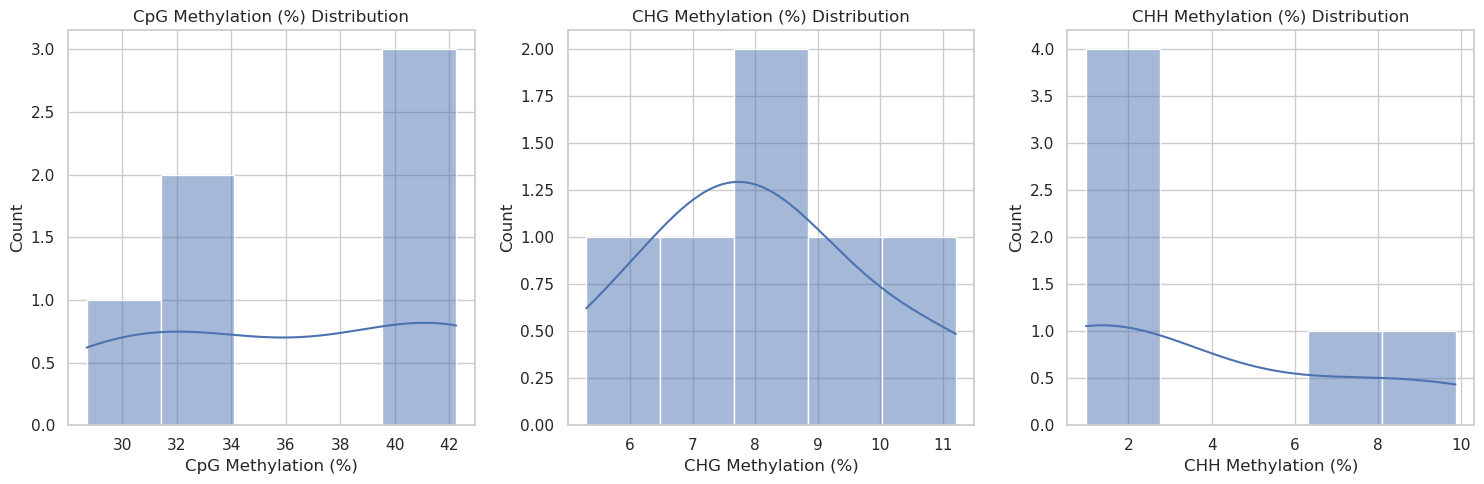

In [108]:
# 2. Distribution of methylation percentages
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style= 'whitegrid')

# Plot histogram for methylation percentages
fig,axes = plt.subplots(1,3, figsize = (15,5))
sns.histplot(df['CpG Methylation (%)'], bins = 5, kde=True, ax=axes[0])
axes[0].set_title("CpG Methylation (%) Distribution")

sns.histplot(df['CHG Methylation (%)'], bins = 5, kde = True, ax = axes[1])
axes[1].set_title("CHG Methylation (%) Distribution")

sns.histplot(df['CHH Methylation (%)'], bins = 5, kde = True, ax=axes[2])
axes[2].set_title("CHH Methylation (%) Distribution")

plt.tight_layout()
plt.show()

* Visualization of methylation percentages across CpG, CHG and CHH contexts

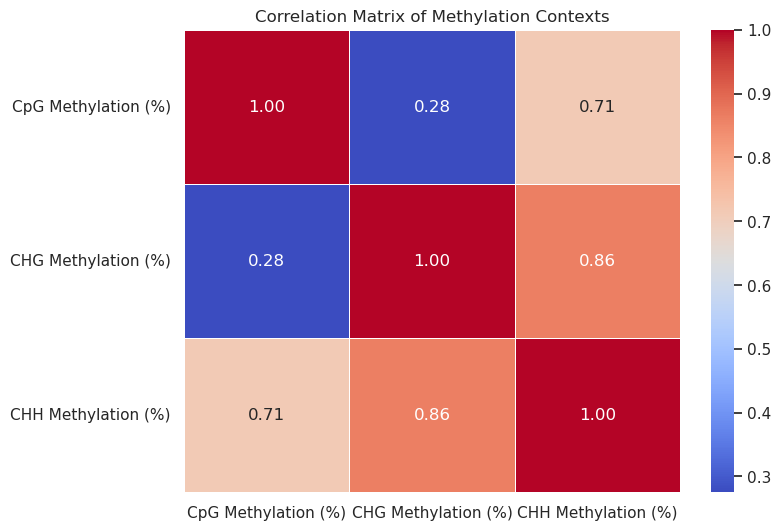

In [109]:
# 3. Correlation between methylation contexts
import numpy as np 

# Compute correlation matrix
corr_matrix = df[["CpG Methylation (%)", "CHG Methylation (%)", "CHH Methylation (%)"]].corr()

# Plot heatmap
plt.figure(figsize= (8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt = ".2f", linewidths=0.5)
plt.title("Correlation Matrix of Methylation Contexts")
plt.show()


Pearson correlation shows that there is higher correlation of CHH Methylation with both CHG methylation and CpG methylation but weak correlation between CpG methylation and CHG methylation.

/tmp/ipykernel_1184229/563090311.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Context", y="Methylation Percentage", data=df_melted, palette="Set2")


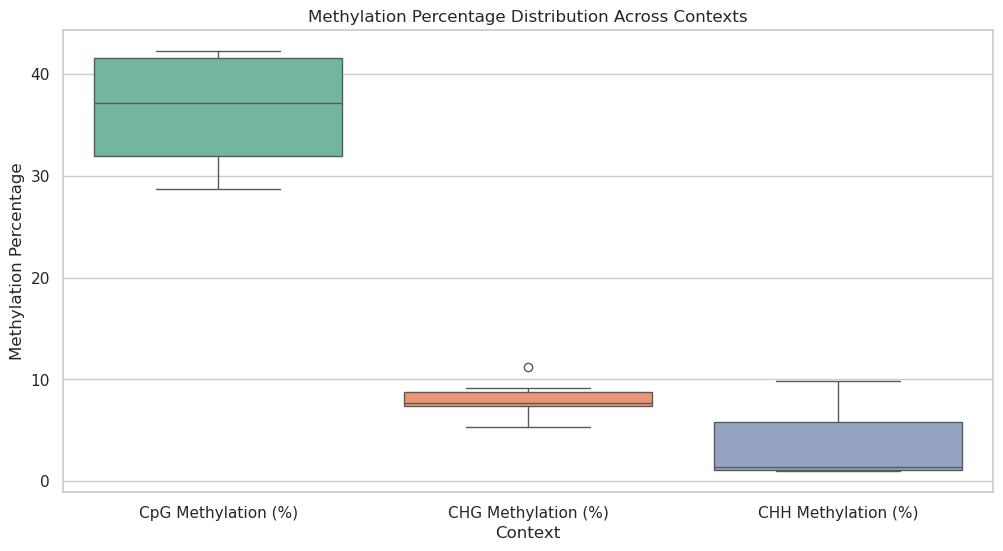

In [110]:
# 4.Box plot for sample comparison
# Convert data to long format for seaborn
df_melted = df.melt(id_vars=["Sample ID"], 
                     value_vars=["CpG Methylation (%)", "CHG Methylation (%)", "CHH Methylation (%)"],
                     var_name="Context", value_name="Methylation Percentage")

# Plot boxplots for each sample
plt.figure(figsize=(12, 6))
sns.boxplot(x="Context", y="Methylation Percentage", data=df_melted, palette="Set2")
plt.title("Methylation Percentage Distribution Across Contexts")
plt.show()

/tmp/ipykernel_1184229/3618976013.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Context", y="Methylation Percentage", data=df_melted, palette="muted")


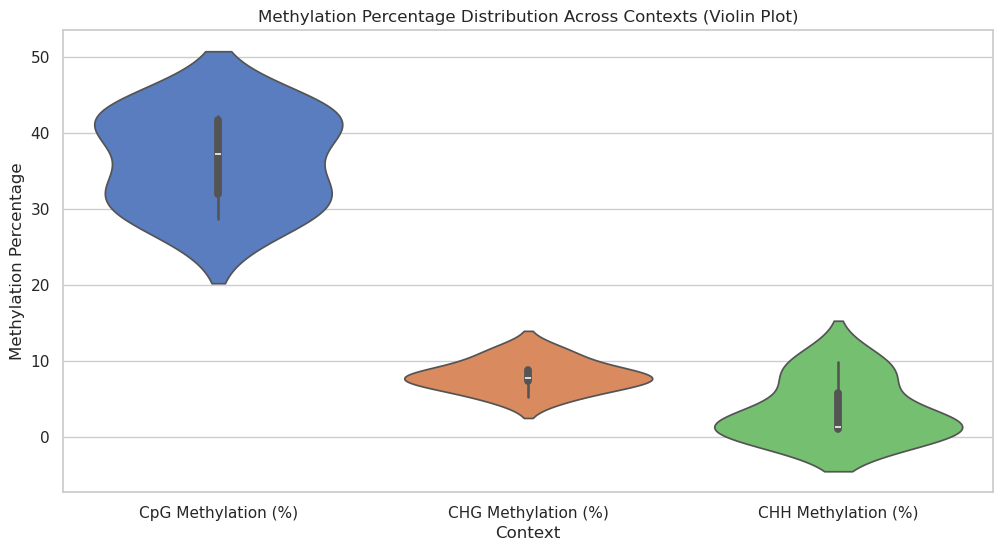

In [111]:
# 5. Violin plots for methylation distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x="Context", y="Methylation Percentage", data=df_melted, palette="muted")
plt.title("Methylation Percentage Distribution Across Contexts (Violin Plot)")
plt.show()

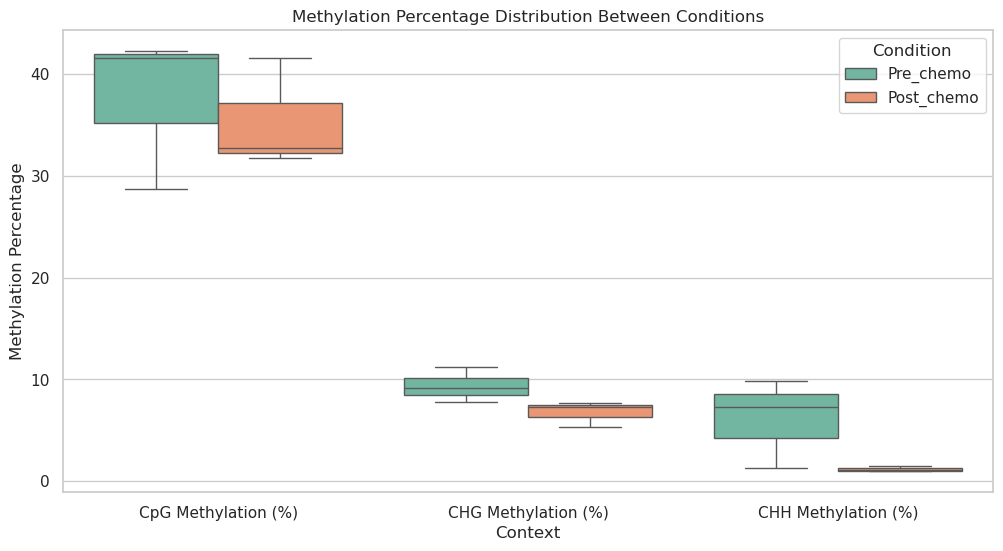

In [116]:
# 1.6 Boxplot of Methylation Between Conditions
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure you have a 'Condition' column in your data
# If not, manually create a mapping (e.g., 'Condition A' and 'Condition B')
condition_map = {
    "SRR19127197": "Pre_chemo",
    "SRR19127198": "Pre_chemo",
    "SRR19127202": "Pre_chemo",
    "SRR19127177": "Post_chemo",
    "SRR19127178": "Post_chemo",
    "SRR19127182": "Post_chemo",
}
df["Condition"] = df["Sample ID"].map(condition_map)

# Convert data to long format for seaborn
df_melted = df.melt(id_vars=["Sample ID", "Condition"], 
                     value_vars=["CpG Methylation (%)", "CHG Methylation (%)", "CHH Methylation (%)"],
                     var_name="Context", value_name="Methylation Percentage")

# Plot boxplots to compare conditions
plt.figure(figsize=(12, 6))
sns.boxplot(x="Context", y="Methylation Percentage", hue="Condition", data=df_melted, palette="Set2")
plt.title("Methylation Percentage Distribution Between Conditions")
plt.legend(title="Condition")
plt.show()

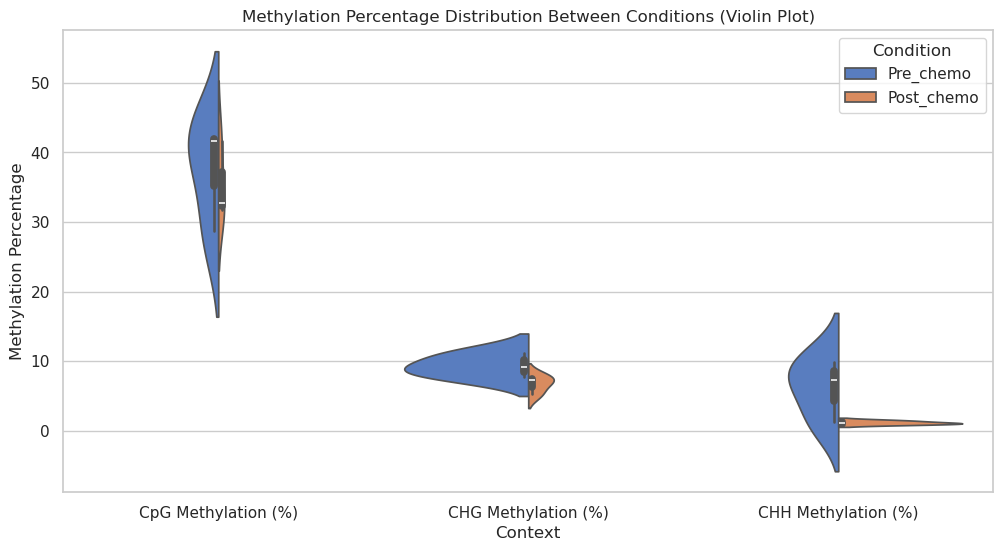

In [117]:
# 7. Violin plot of methylation across conditions
plt.figure(figsize=(12, 6))
sns.violinplot(x="Context", y="Methylation Percentage", hue="Condition", data=df_melted, split=True, palette="muted")
plt.title("Methylation Percentage Distribution Between Conditions (Violin Plot)")
plt.legend(title="Condition")
plt.show()

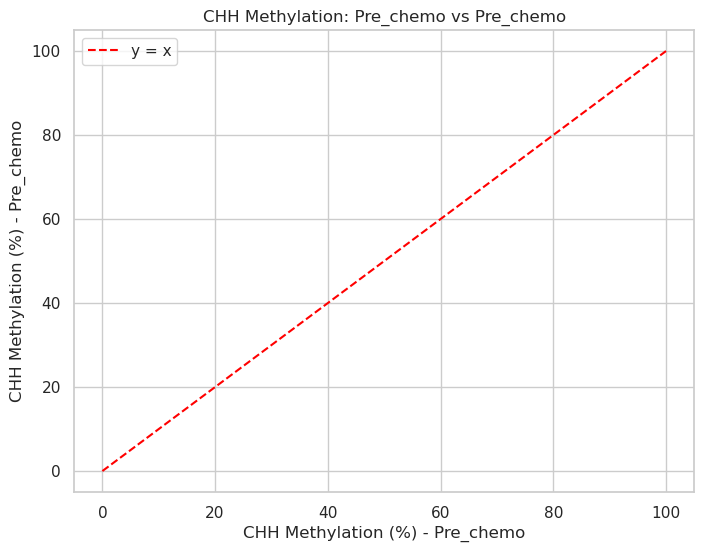

In [119]:
# 7. Scatter plot (Condition A vs Condition B) (can be removed)
import numpy as np

# Pivot DataFrame to compare conditions side by side
df_pivot = df.pivot(index="Sample ID", columns="Condition", values="CHH Methylation (%)").dropna()

# Scatter plot comparing CpG Methylation between conditions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pivot["Pre_chemo"], y=df_pivot["Pre_chemo"], color="blue", alpha=0.7)

# Plot 1:1 line for reference
plt.plot([0, 100], [0, 100], linestyle="--", color="red", label="y = x")
plt.xlabel("CHH Methylation (%) - Pre_chemo")
plt.ylabel("CHH Methylation (%) - Pre_chemo")
plt.title("CHH Methylation: Pre_chemo vs Pre_chemo")
plt.legend()
plt.show()

/home/abhi39/miniconda3/envs/Genomics/lib/python3.9/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/abhi39/miniconda3/envs/Genomics/lib/python3.9/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


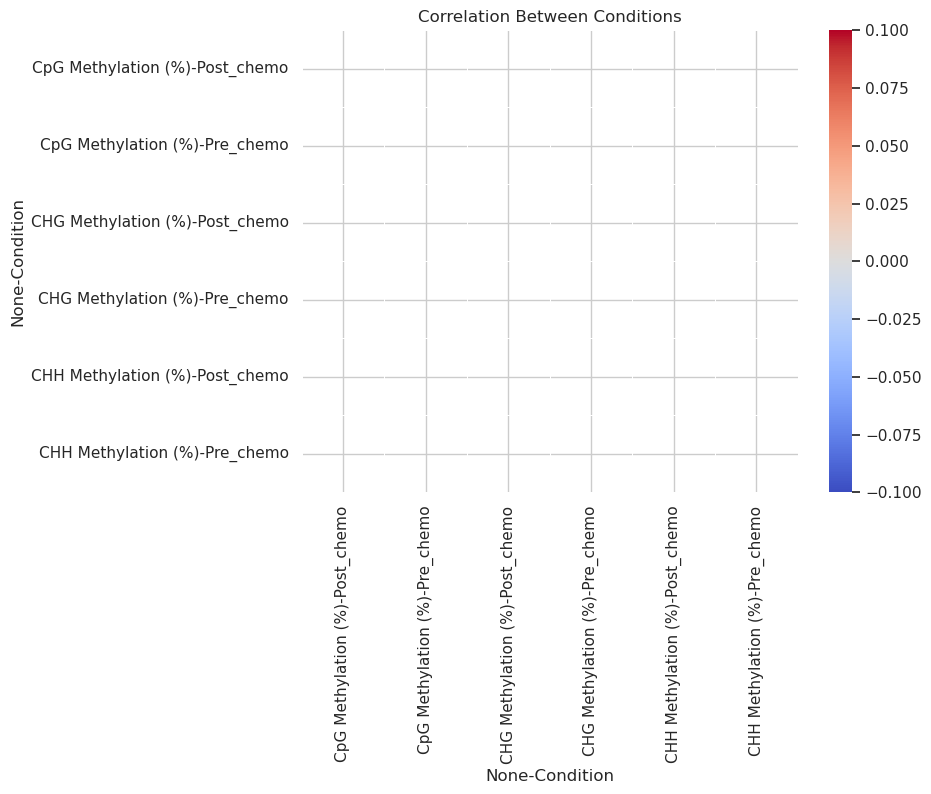

In [ ]:
# 8. Pairwise correlation between conditions (can be removed too)
import numpy as np

# Compute correlation matrix for CpG, CHG, CHH methylation across conditions
correlation_matrix = df.pivot(index="Sample ID", columns="Condition", values=["CpG Methylation (%)", "CHG Methylation (%)", "CHH Methylation (%)"]).dropna().corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Conditions")
plt.show()

#### Step 9: Convert CX report into DSS-compatible format for DML/DMR Analysis
* Convert CX report into DSS format
* Groups data by chromosome and position to create methylation count tables
* This dss_input.csv file is then used for DML/DMR analysis in R

In [121]:
#Convert CX report into DSS-compatible format

import pandas as pd
import os

# Define directories
base_dir = "/home/abhi39/Projects/Bisulfite_seq"
output_dir = os.path.join(base_dir, "output")
methylation_dir = os.path.join(output_dir, "4_methylation_calls")

# List of SRR sample IDs
srr_ids = [
    "SRR19127202",
    "SRR19127177",
    "SRR19127198",
    "SRR19127197",
    "SRR19127182",
    "SRR19127178"
]

# Define condition mapping
condition_map = {
    "SRR19127197": "Pre_chemo",
    "SRR19127198": "Pre_chemo",
    "SRR19127202": "Pre_chemo",
    "SRR19127177": "Post_chemo",
    "SRR19127178": "Post_chemo",
    "SRR19127182": "Post_chemo",
}

# Initialize an empty list to store data for DSS
dss_data = []

# Process each CX report
for sample_id in srr_ids:
    cx_report_path = os.path.join(methylation_dir, f"CX_report_{sample_id}.txt")

    if not os.path.exists(cx_report_path):
        print(f"Warning: {cx_report_path} not found! Skipping...")
        continue

    print(f"Processing CX report for {sample_id}...")

    # Read CX report
    col_names = ["Read_ID", "Strand", "Chromosome", "Position", "Methylation_Status"]
    df = pd.read_csv(cx_report_path, sep="\t", names=col_names, comment="#", header=None)

    # Convert Methylation Status to Counts
    df["Total_C"] = 1  # Each row represents one cytosine observation
    df["Methylated_C"] = df["Methylation_Status"].apply(lambda x: 1 if x in ["Z", "X", "H"] else 0)

    # Group by Chromosome & Position
    dss_summary = df.groupby(["Chromosome", "Position"]).agg(
        Total_C=("Total_C", "sum"),
        Methylated_C=("Methylated_C", "sum")
    ).reset_index()

    # Add Sample ID & Condition
    dss_summary["Sample_ID"] = sample_id
    dss_summary["Condition"] = condition_map[sample_id]

    # Append to list
    dss_data.append(dss_summary)

# Combine all data into one DataFrame
dss_df = pd.concat(dss_data, ignore_index=True)

# Save to CSV for DSS analysis in R
dss_output_path = os.path.join(methylation_dir, "dss_input.csv")
dss_df.to_csv(dss_output_path, index=False)

print(f"DSS-compatible file saved to {dss_output_path}")

Processing CX report for SRR19127202...
Processing CX report for SRR19127177...
Processing CX report for SRR19127198...
Processing CX report for SRR19127197...
Processing CX report for SRR19127182...
Processing CX report for SRR19127178...
DSS-compatible file saved to /home/abhi39/Projects/Bisulfite_seq/output/4_methylation_calls/dss_input.csv


##### Proceed further in R!!!

#########################################################################################